In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

### 1. Data Loading and Exploration

In [2]:
data_dir = "data/mood"

# Load datasets with proper handling of blank lines
train_df = pd.read_csv(
    f"{data_dir}/TrainSet.csv", skipinitialspace=True, skip_blank_lines=True
)
test_df = pd.read_csv(
    f"{data_dir}/TestSet.csv", skipinitialspace=True, skip_blank_lines=True
)

# Display initial information about missing values
print("Initial missing values in training set:", train_df.isnull().sum().sum())
print("Initial missing values in test set:", test_df.isnull().sum().sum())


# Function to explore dataset
def explore_dataset(df, name):
    print(f"=== {name} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"\nClass distribution:")
    print(df["class"].value_counts())

    # Detailed missing value analysis
    missing_vals = df.isnull().sum()
    missing_cols = missing_vals[missing_vals > 0]
    print(f"\nColumns with missing values: {len(missing_cols)}")
    if len(missing_cols) > 0:
        print(missing_cols)
    print(f"Total missing values: {missing_vals.sum()}")

    print("\nSample data:")
    print(df.head(2))

    # Check for potential outliers
    print("\nFeature statistics:")
    print(df.describe().T[["min", "max", "mean", "std"]])


# Explore both datasets
explore_dataset(train_df, "Training")
explore_dataset(test_df, "Test")

Initial missing values in training set: 122
Initial missing values in test set: 47
=== Training Dataset ===
Shape: (60, 68)

Class distribution:
class
aggressive    15
happy         15
relaxed       15
sad           15
Name: count, dtype: int64

Columns with missing values: 6
Tm     2
Td     2
Im    55
Id    55
Bm     4
Bd     4
dtype: int64
Total missing values: 122

Sample data:
                         File_Name        Em        Ed        El       LEm  \
0  01-anarchy_in_the_uk.mp3         0.228523  0.005756  0.003345  0.563593   
1     01-angel_of_death.mp3         0.231866  0.007204  0.005113  0.529508   

        ATm           Asm           ASd       EDm     FPm  ...       D7m  \
0  0.057984  3.457377e+06  2.521368e+06  5.243943   866.0  ... -0.000118   
1  0.049326  6.534186e+06  3.843431e+06  7.434451  1345.0  ...  0.000176   

         RSm        RSd        RRm        RRd        RTm        RTd  \
0  43.800431  21.912391  55.806736  57.279056  41.248632  21.913723   
1  28.2424

### 2. Feature Categorization

In [3]:
# Create a mapping from acronyms to full feature names based on the table
feature_full_names = {
    # Dynamics
    "Em": "RMS Energy (mean)",
    "Ed": "RMS Energy (deviation)",
    "El": "RMS Energy (slope)",
    "LEm": "Low-energy Ratio",
    "ATm": "Attack Time",
    "ASm": "Attack Slope (mean)",
    "ASd": "Attack Slope (deviation)",
    # Rhythm
    "EDm": "Event Density",
    "FPm": "Fluctuation Peak (position)",
    "FMm": "Fluctuation Peak (magnitude)",
    "FCm": "Fluctuation Centroid",
    "Tm": "Tempo (mean)",
    "Td": "Tempo (deviation)",
    "PCm": "Pulse Clarity (mean)",
    "PCd": "Pulse Clarity (deviation)",
    # Pitch
    "Pm": "Pitch (mean)",
    "Pd": "Pitch (deviation)",
    "Cm": "Chromagram (unwrapped) center (mean)",
    "Cd": "Chromagram (unwrapped) center (deviation)",
    "Cl": "Chromagram (unwrapped) center (slope)",
    "Chh": "Chromagram (unwrapped) center (entropy)",
    # Harmony
    "KCm": "Key Clarity (mean)",
    "KCd": "Key Clarity (deviation)",
    "Mm": "Key Mode - majorness (mean)",
    "Md": "Key Mode - majorness (deviation)",
    "Hm": "HCDF",
    "ESm": "Entropy (oct. collapsed spectr.)",
    "Rm": "Roughness",
    "Im": "Inharmonicity (mean)",
    "Id": "Inharmonicity (deviation)",
    # Timbre
    "Bm": "Brightness (mean)",
    "Bd": "Brightness (deviation)",
    "SCm": "Spectral Centroid (mean)",
    "SCd": "Spectral Centroid (deviation)",
    "Zm": "Zerocross (mean)",
    "Zd": "Zerocross (deviation)",
    "Sm": "Spread",
    "Km": "Skewness",
    "SEm": "Spectral Entropy (mean)",
    "SEd": "Spectral Entropy (deviation)",
    "SFm": "Spectral Flux",
    "Fm": "Flatness",
    "REm": "Regularity (mean)",
    "REd": "Regularity (deviation)",
    "M1m": "1st MFCC (mean)",
    "D1m": "1st MFCC (deviation)",
    "M2m": "2nd MFCC (mean)",
    "D2m": "2nd MFCC (deviation)",
    "M3m": "3rd MFCC (mean)",
    "D3m": "3rd MFCC (deviation)",
    "M4m": "4th MFCC (mean)",
    "D4m": "4th MFCC (deviation)",
    "M5m": "5th MFCC (mean)",
    "D5m": "5th MFCC (deviation)",
    "M6m": "6th MFCC (mean)",
    "D6m": "6th MFCC (deviation)",
    "M7m": "7th MFCC (mean)",
    "D7m": "7th MFCC (deviation)",
    # Structure
    "RSm": "Repetition (spectrum) (mean)",
    "RSd": "Repetition (spectrum) (deviation)",
    "RRm": "Repetition (rhythm) (mean)",
    "RRd": "Repetition (rhythm) (deviation)",
    "RTm": "Repetition (tonality) (mean)",
    "RTd": "Repetition (tonality) (deviation)",
    "RGm": "Repetition (register) (mean)",
    "RGd": "Repetition (register) (deviation)",
}


# Function to get full feature name or use acronym if not found
def get_full_feature_name(acronym):
    return feature_full_names.get(acronym, acronym)


# Define feature categories (based on the assignment table)
feature_categories = {
    "dynamics": ["Em", "Ed", "El", "LEm", "ATm", "ASm", "ASd"],
    "rhythm": ["EDm", "FPm", "FMm", "FCm", "Tm", "Td", "PCm", "PCd"],
    "pitch": ["Pm", "Pd", "Cm", "Cd", "Cl", "Chh"],
    "harmony": ["KCm", "KCd", "Mm", "Md", "Hm", "ESm", "Rm", "Im", "Id"],
    "timbre": [
        "Bm",
        "Bd",
        "SCm",
        "SCd",
        "Zm",
        "Zd",
        "Sm",
        "Km",
        "SEm",
        "SEd",
        "SFm",
        "Fm",
        "REm",
        "REd",
        "M1m",
        "D1m",
        "M2m",
        "D2m",
        "M3m",
        "D3m",
        "M4m",
        "D4m",
        "M5m",
        "D5m",
        "M6m",
        "D6m",
        "M7m",
        "D7m",
    ],
    "structure": ["RSm", "RSd", "RRm", "RRd", "RTm", "RTd", "RGm", "RGd"],
}

# Get all feature names (excluding File_Name and class)
all_features = [col for col in train_df.columns if col not in ["File_Name", "class"]]

# Print available feature names to debug
print("\nAvailable features in dataset:")
print(sorted(all_features))


# Validate feature categories against available features
print("\nValidating feature categories against available columns:")
for category, features in feature_categories.items():
    invalid_features = [f for f in features if f not in all_features]
    if invalid_features:
        print(
            f"Warning: Category '{category}' contains {len(invalid_features)} invalid features: {invalid_features}"
        )
        # Remove invalid features
        feature_categories[category] = [f for f in features if f in all_features]
        print(f"  - Updated '{category}' feature list to only include valid features")
    else:
        print(f"Category '{category}': All {len(features)} features are valid")



Available features in dataset:
['ASd', 'ATm', 'Asm', 'Bd', 'Bm', 'Cd', 'Chh', 'Cl', 'Cm', 'D1m', 'D2m', 'D3m', 'D4m', 'D5m', 'D6m', 'D7m', 'EDm', 'ESm', 'Ed', 'El', 'Em', 'FCm', 'FMm', 'FPm', 'Fm', 'Hm', 'Id', 'Im', 'KCd', 'KCm', 'Km', 'LEm', 'M1m', 'M2m', 'M3m', 'M4m', 'M5m', 'M6m', 'M7m', 'Md', 'Mm', 'PCd', 'PCm', 'Pd', 'Pm', 'REd', 'REm', 'RGd', 'RGm', 'RRd', 'RRm', 'RSd', 'RSm', 'RTd', 'RTm', 'Rm', 'SCd', 'SCm', 'SEd', 'SEm', 'SFm', 'Sm', 'Td', 'Tm', 'Zd', 'Zm']

Validating feature categories against available columns:
  - Updated 'dynamics' feature list to only include valid features
Category 'rhythm': All 8 features are valid
Category 'pitch': All 6 features are valid
Category 'harmony': All 9 features are valid
Category 'timbre': All 28 features are valid
Category 'structure': All 8 features are valid


### 3. Data Preprocessing

In [4]:
# Handle missing values
print("\n=== Handling Missing Values ===")

# Check for any string columns that should be numeric
for col in all_features:
    if train_df[col].dtype == "object":
        print(f"Converting column {col} from object to numeric")
        train_df[col] = pd.to_numeric(train_df[col], errors="coerce")
    if test_df[col].dtype == "object":
        print(f"Converting column {col} from object to numeric")
        test_df[col] = pd.to_numeric(test_df[col], errors="coerce")

# Impute missing values
print("Imputing missing values using KNN imputation...")
# Use KNN imputation which tends to preserve relationships between features
imputer = KNNImputer(n_neighbors=5)
train_imputed = pd.DataFrame(
    imputer.fit_transform(train_df[all_features]), columns=all_features
)
test_imputed = pd.DataFrame(
    imputer.transform(test_df[all_features]), columns=all_features
)

print(f"Missing values after imputation (train): {train_imputed.isnull().sum().sum()}")
print(f"Missing values after imputation (test): {test_imputed.isnull().sum().sum()}")

# Check for any remaining issues
if train_imputed.isnull().sum().sum() > 0 or test_imputed.isnull().sum().sum() > 0:
    print("Warning: Some missing values remain after imputation!")
    # As a fallback, fill any remaining missing values with column means
    train_imputed = train_imputed.fillna(train_imputed.mean())
    test_imputed = test_imputed.fillna(
        train_imputed.mean()
    )  # Use training means for test data


=== Handling Missing Values ===
Converting column SCm from object to numeric
Converting column SCm from object to numeric
Converting column SCd from object to numeric
Converting column SCd from object to numeric
Imputing missing values using KNN imputation...
Missing values after imputation (train): 0
Missing values after imputation (test): 0


In [5]:
# Separate features and target
X_train = train_imputed
y_train = train_df["class"]
X_test = test_imputed
y_test = test_df["class"]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier manipulation
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=all_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=all_features)

### 4. Visualizations

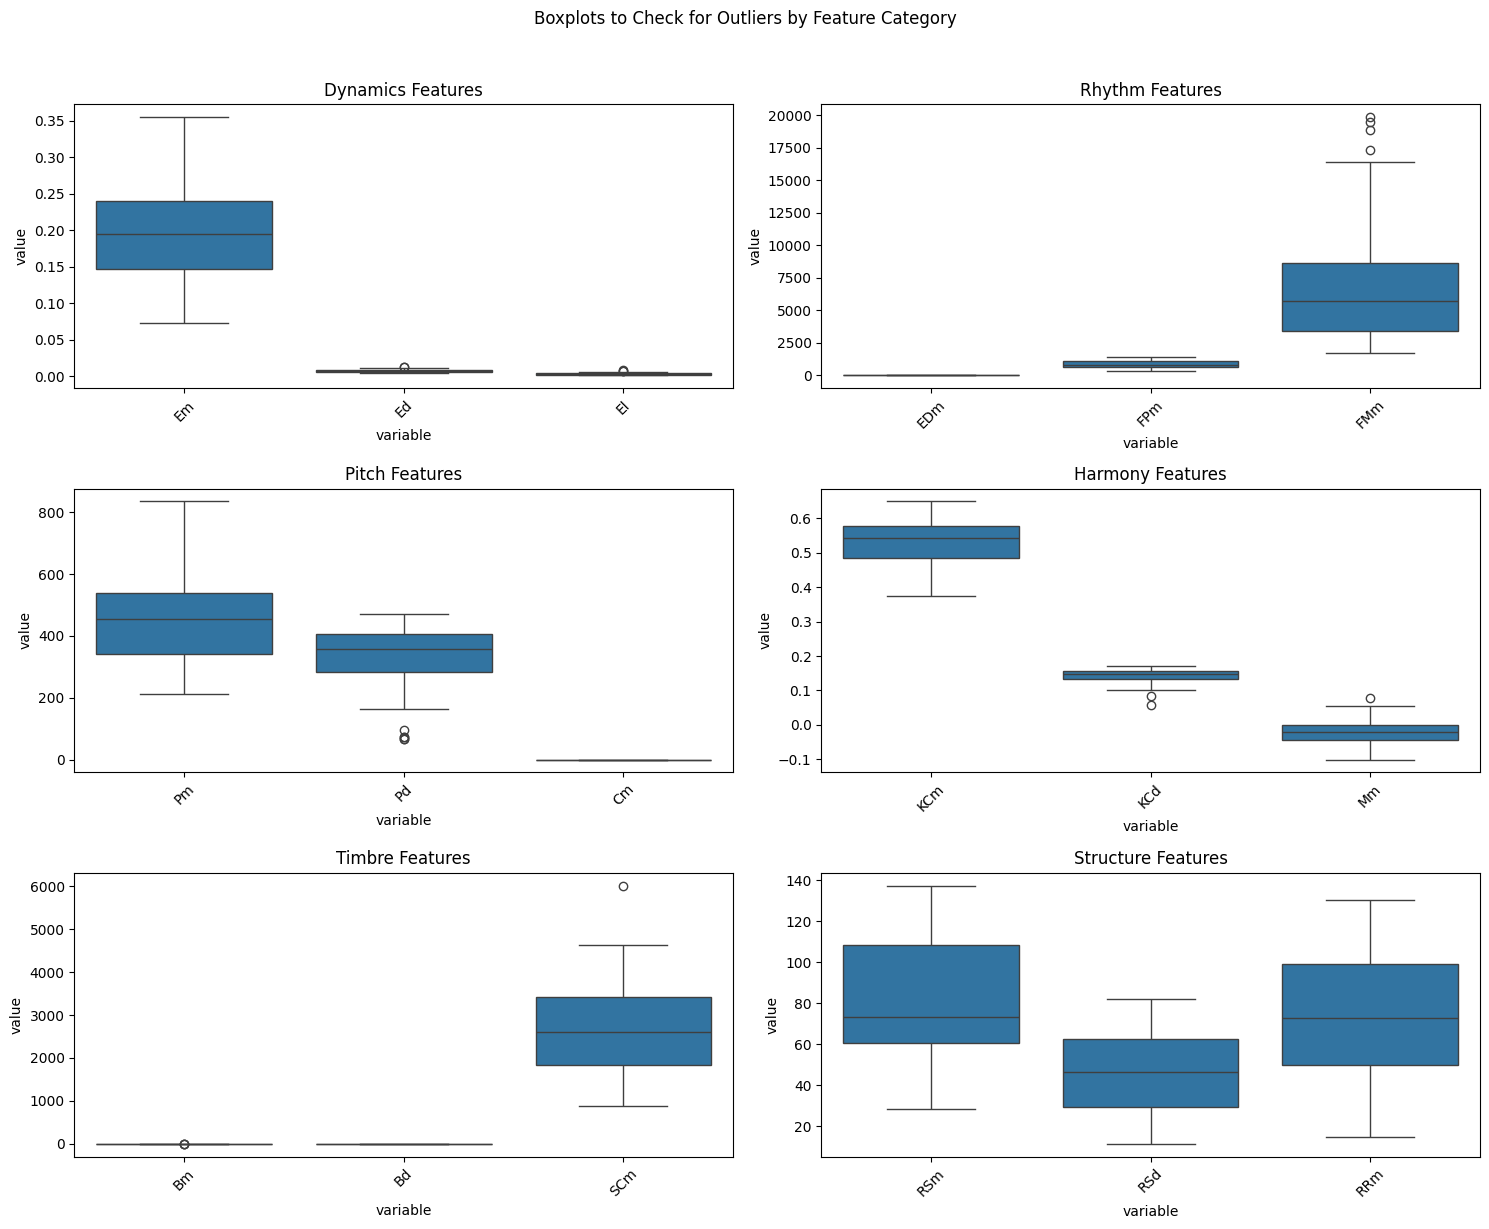

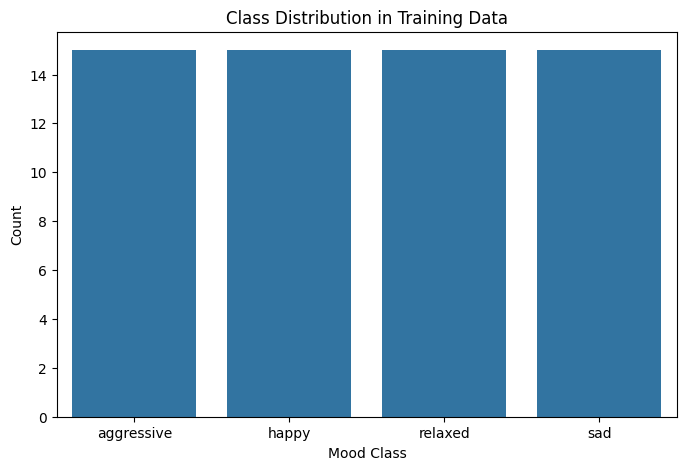

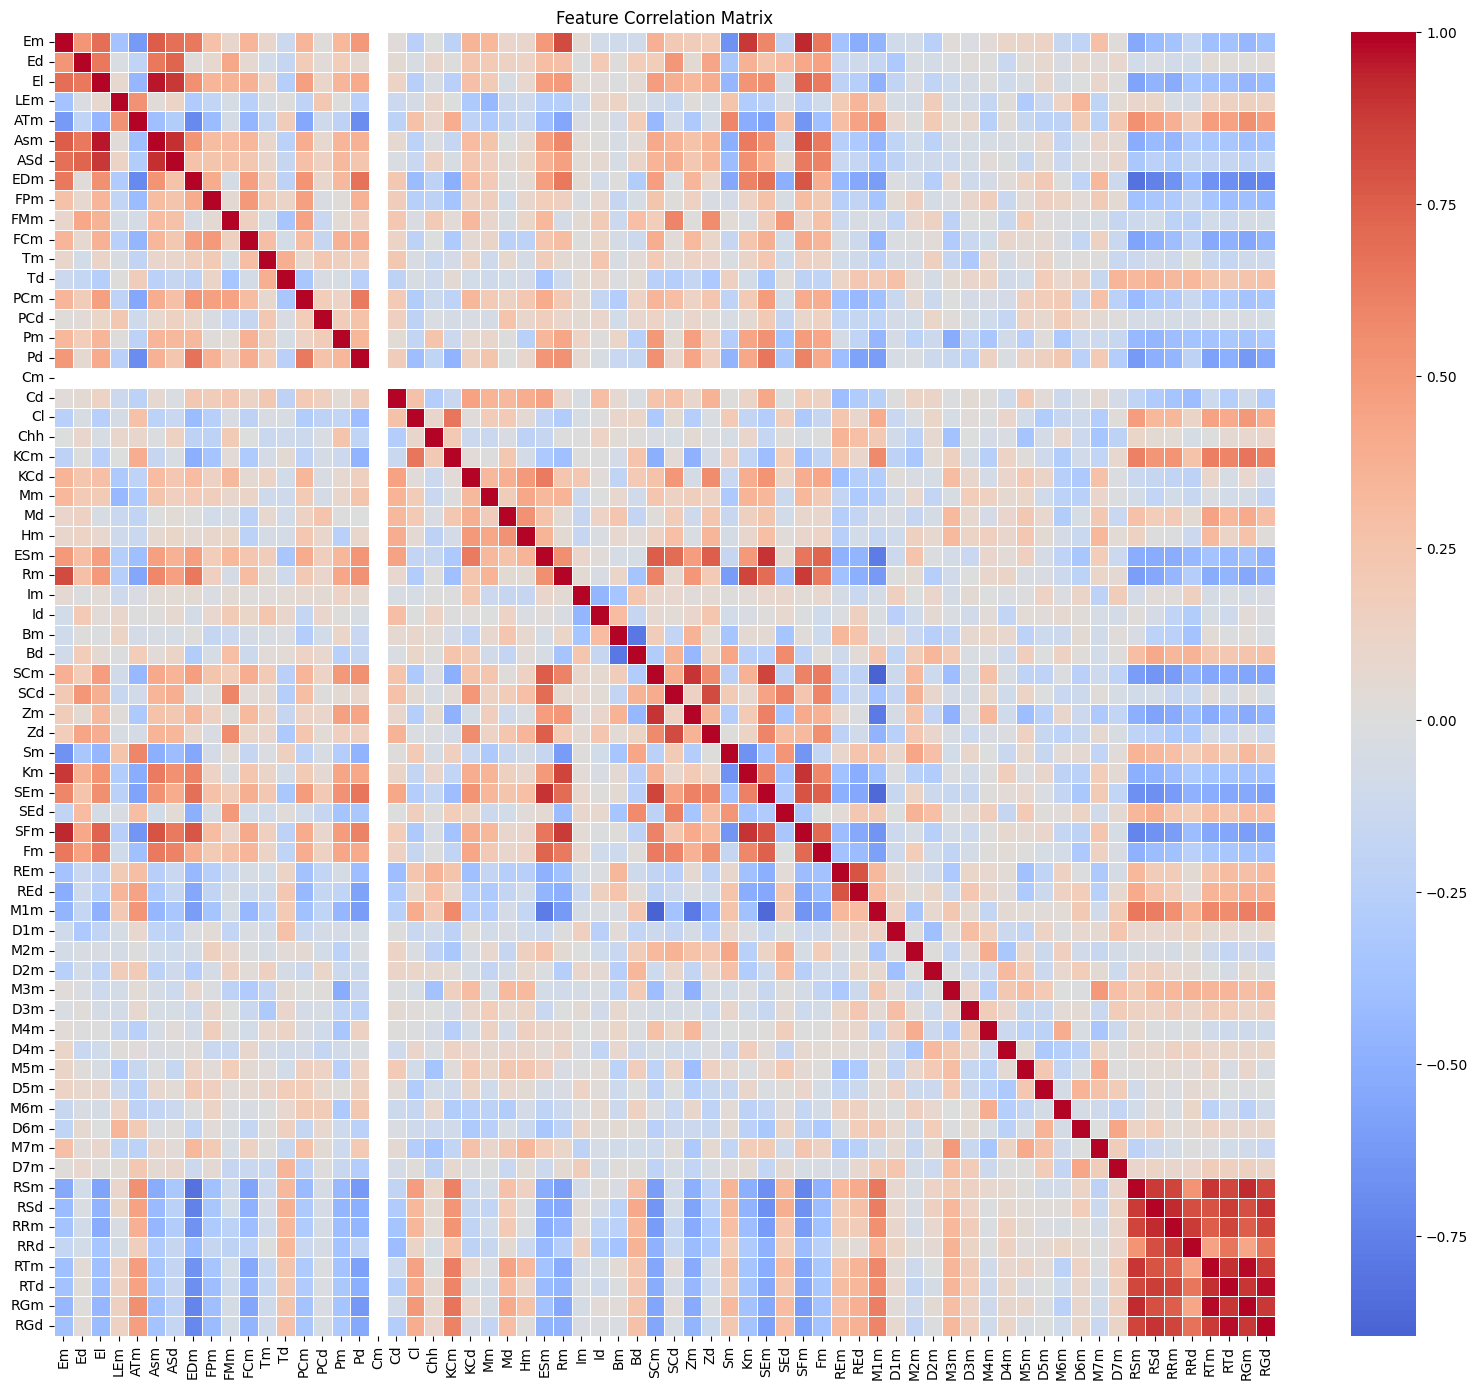

In [6]:
# Check for outliers in the dataset
def plot_boxplots_by_category(df, categories_dict, n_features=3):
    """Plot boxplots for top n features from each category to check for outliers"""
    plt.figure(figsize=(15, 12))
    category_count = len(categories_dict)
    rows = (category_count + 1) // 2  # Calculate rows needed

    for i, (category, features) in enumerate(categories_dict.items()):
        if len(features) == 0:
            continue

        # Select subset of features to display
        display_features = features[:n_features]

        plt.subplot(rows, 2, i + 1)
        # Melt the dataframe for easier boxplot creation
        df_melt = pd.melt(df[display_features])
        sns.boxplot(x="variable", y="value", data=df_melt)
        plt.title(f"{category.capitalize()} Features")
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.suptitle("Boxplots to Check for Outliers by Feature Category", y=1.02)
    plt.tight_layout()
    plt.show()


# Plot boxplots to check for outliers
plot_boxplots_by_category(X_train, feature_categories)

# Class distribution visualization
plt.figure(figsize=(8, 5))
sns.countplot(x="class", data=train_df)
plt.title("Class Distribution in Training Data")
plt.xlabel("Mood Class")
plt.ylabel("Count")
plt.show()

# Correlation matrix for features
plt.figure(figsize=(16, 14))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, linewidths=0.5, annot=False)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

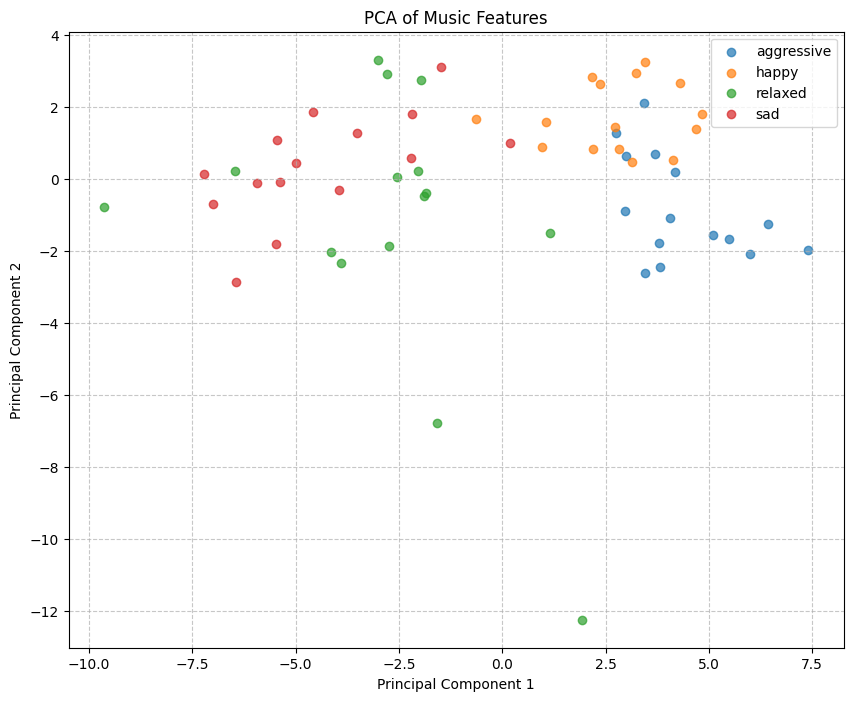

In [7]:
# PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
for mood in np.unique(y_train):
    idx = np.where(y_train == mood)
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=mood, alpha=0.7)

plt.title("PCA of Music Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

### 5. Feature Selection

In [8]:
# Function to perform feature selection and return best features
def select_features(X, y, method="anova", k=15):
    if method == "anova":
        selector = SelectKBest(f_classif, k=k)
    elif method == "mutual_info":
        selector = SelectKBest(mutual_info_classif, k=k)

    selector.fit(X, y)
    scores = selector.scores_
    feature_indices = selector.get_support(indices=True)
    selected_features = [all_features[i] for i in feature_indices]

    # Create dataframe of features and their scores
    feature_scores = pd.DataFrame({"Feature": all_features, "Score": scores})
    feature_scores = feature_scores.sort_values("Score", ascending=False)

    return selected_features, feature_scores


# Perform feature selection using different methods
try:
    anova_features, anova_scores = select_features(
        X_train_scaled, y_train, method="anova", k=20
    )
    mutual_info_features, mutual_info_scores = select_features(
        X_train_scaled, y_train, method="mutual_info", k=20
    )

    # Display top features from each method
    print("\nTop Features (ANOVA F-value):")
    print(anova_scores.head(20))

    print("\nTop Features (Mutual Information):")
    print(mutual_info_scores.head(20))
except Exception as e:
    print(f"Error during feature selection: {str(e)}")
    # Create empty variables to prevent errors later
    anova_features = []
    anova_scores = pd.DataFrame(columns=["Feature", "Score"])
    mutual_info_features = []
    mutual_info_scores = pd.DataFrame(columns=["Feature", "Score"])



Top Features (ANOVA F-value):
   Feature      Score
40     SFm  51.880142
7      EDm  38.455252
58     RSm  35.630804
38     SEm  32.746549
0       Em  22.564186
41      Fm  21.875438
2       El  21.845321
64     RGm  21.511067
5      Asm  21.065563
27      Rm  20.508576
62     RTm  18.399276
59     RSd  18.271724
26     ESm  17.876050
60     RRm  17.470932
37      Km  17.345572
63     RTd  17.128592
65     RGd  16.662909
44     M1m  16.341412
32     SCm  12.035877
22     KCd  12.005482

Top Features (Mutual Information):
   Feature     Score
58     RSm  0.598098
40     SFm  0.577439
7      EDm  0.570132
62     RTm  0.558269
64     RGm  0.535637
44     M1m  0.518227
5      Asm  0.514639
38     SEm  0.491480
60     RRm  0.466381
0       Em  0.464752
2       El  0.462575
65     RGd  0.456411
63     RTd  0.444610
34      Zm  0.442969
41      Fm  0.433197
4      ATm  0.432359
32     SCm  0.409251
37      Km  0.399454
27      Rm  0.381178
26     ESm  0.379119


In [9]:
# Display top features from each method
print("\nTop Features (ANOVA F-value):")
print(anova_scores.head(20))

print("\nTop Features (Mutual Information):")
print(mutual_info_scores.head(20))


Top Features (ANOVA F-value):
   Feature      Score
40     SFm  51.880142
7      EDm  38.455252
58     RSm  35.630804
38     SEm  32.746549
0       Em  22.564186
41      Fm  21.875438
2       El  21.845321
64     RGm  21.511067
5      Asm  21.065563
27      Rm  20.508576
62     RTm  18.399276
59     RSd  18.271724
26     ESm  17.876050
60     RRm  17.470932
37      Km  17.345572
63     RTd  17.128592
65     RGd  16.662909
44     M1m  16.341412
32     SCm  12.035877
22     KCd  12.005482

Top Features (Mutual Information):
   Feature     Score
58     RSm  0.598098
40     SFm  0.577439
7      EDm  0.570132
62     RTm  0.558269
64     RGm  0.535637
44     M1m  0.518227
5      Asm  0.514639
38     SEm  0.491480
60     RRm  0.466381
0       Em  0.464752
2       El  0.462575
65     RGd  0.456411
63     RTd  0.444610
34      Zm  0.442969
41      Fm  0.433197
4      ATm  0.432359
32     SCm  0.409251
37      Km  0.399454
27      Rm  0.381178
26     ESm  0.379119



Top Features (Random Forest Importance):
   Feature  Importance
40     SFm    0.057081
58     RSm    0.049535
7      EDm    0.043168
64     RGm    0.040465
2       El    0.038081
62     RTm    0.034345
21     KCm    0.033019
65     RGd    0.028190
38     SEm    0.027450
35      Zd    0.027366
4      ATm    0.026669
0       Em    0.026119
5      Asm    0.025410
63     RTd    0.024038
8      FPm    0.022767
27      Rm    0.022315
41      Fm    0.021779
10     FCm    0.021313
37      Km    0.020708
26     ESm    0.020043


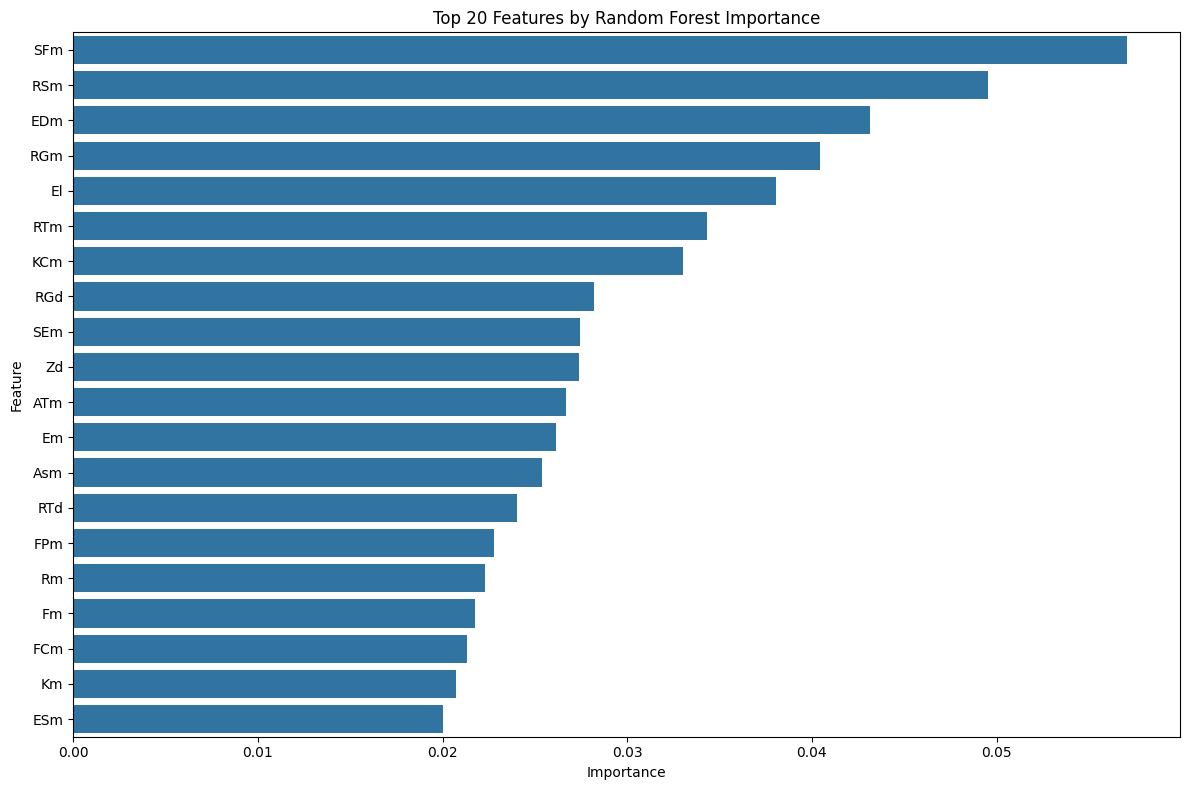

In [10]:
# Feature importance using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_importances = pd.DataFrame(
    {"Feature": all_features, "Importance": rf_model.feature_importances_}
).sort_values("Importance", ascending=False)

print("\nTop Features (Random Forest Importance):")
print(rf_importances.head(20))

# Plot top 20 features by importance
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=rf_importances.head(20))
plt.title("Top 20 Features by Random Forest Importance")
plt.tight_layout()
plt.show()

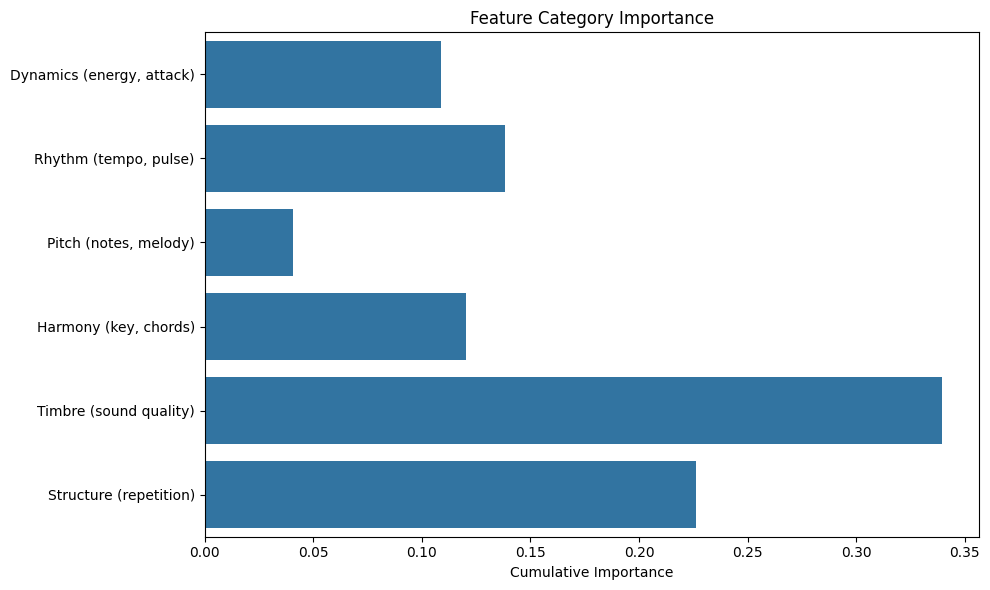

In [11]:
# Analyze importance by feature category
category_importance = {}

category_full_names = {
    "dynamics": "Dynamics (energy, attack)",
    "rhythm": "Rhythm (tempo, pulse)",
    "pitch": "Pitch (notes, melody)",
    "harmony": "Harmony (key, chords)",
    "timbre": "Timbre (sound quality)",
    "structure": "Structure (repetition)",
}

for category, features in feature_categories.items():
    # Get features that exist in both our data and the category
    common_features = [f for f in features if f in rf_importances["Feature"].values]
    if common_features:
        category_scores = rf_importances[
            rf_importances["Feature"].isin(common_features)
        ]["Importance"].sum()
        category_importance[category] = category_scores

plt.figure(figsize=(10, 6))
categories = list(category_importance.keys())
importances = list(category_importance.values())
category_labels = [category_full_names.get(c, c) for c in categories]
sns.barplot(x=importances, y=category_labels)
plt.title("Feature Category Importance")
plt.xlabel("Cumulative Importance")
plt.tight_layout()
plt.show()


### 6. Model Training and Evaluation

In [12]:
# Set up confusion matrix plot management
confusion_matrices = []
cm_model_names = []


# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f"\n=== {model_name} ===")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Store confusion matrix for later plotting
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append((cm, model_name, np.unique(y_test)))

    # Plot confusion matrices in batches of 6
    if len(confusion_matrices) % 6 == 0:
        plot_confusion_matrix_grid()

    return accuracy, y_pred


# Function to plot a grid of confusion matrices
def plot_confusion_matrix_grid():
    # Get the matrices to plot (the last 6 or fewer)
    start_idx = max(0, len(confusion_matrices) - 6)
    matrices_to_plot = confusion_matrices[start_idx:]
    n_matrices = len(matrices_to_plot)

    # Set up the grid (2x3)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Plot each confusion matrix
    for i, (cm, model_name, classes) in enumerate(matrices_to_plot):
        if i < len(axes):
            ax = axes[i]
            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=classes,
                yticklabels=classes,
                ax=ax,
            )
            ax.set_title(f"Confusion Matrix - {model_name}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")

    # Hide unused subplots
    for i in range(n_matrices, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Create different feature sets
# 1. All features
# 2. Top 20 ANOVA features
# 3. Top 20 RandomForest features
# 4. Feature sets by category (dynamics, rhythm, etc.)

feature_sets = {"all_features": all_features}

# Only add feature selection sets if they were successfully created
if "anova_features" in locals() and len(anova_features) > 0:
    feature_sets["anova_top20"] = anova_features
if "rf_importances" in locals() and len(rf_importances) > 0:
    feature_sets["rf_top20"] = rf_importances["Feature"].head(20).tolist()

# Add feature sets by category
for category, features in feature_categories.items():
    # Only add if there are valid features
    if features:
        feature_sets[f"{category}_features"] = features

# Create and evaluate different models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(100,), max_iter=1000, random_state=42
    ),
}



=== Feature Set: all_features (66 features) ===

=== Random Forest with all_features ===
Test Accuracy: 0.7000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.83      1.00      0.91         5
       happy       0.67      0.80      0.73         5
     relaxed       1.00      0.20      0.33         5
         sad       0.57      0.80      0.67         5

    accuracy                           0.70        20
   macro avg       0.77      0.70      0.66        20
weighted avg       0.77      0.70      0.66        20


=== SVM with all_features ===
Test Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.83      1.00      0.91         5
       happy       0.67      0.80      0.73         5
     relaxed       0.33      0.20      0.25         5
         sad       0.40      0.40      0.40         5

    accuracy                           0.60        20
   macro avg       0.56  

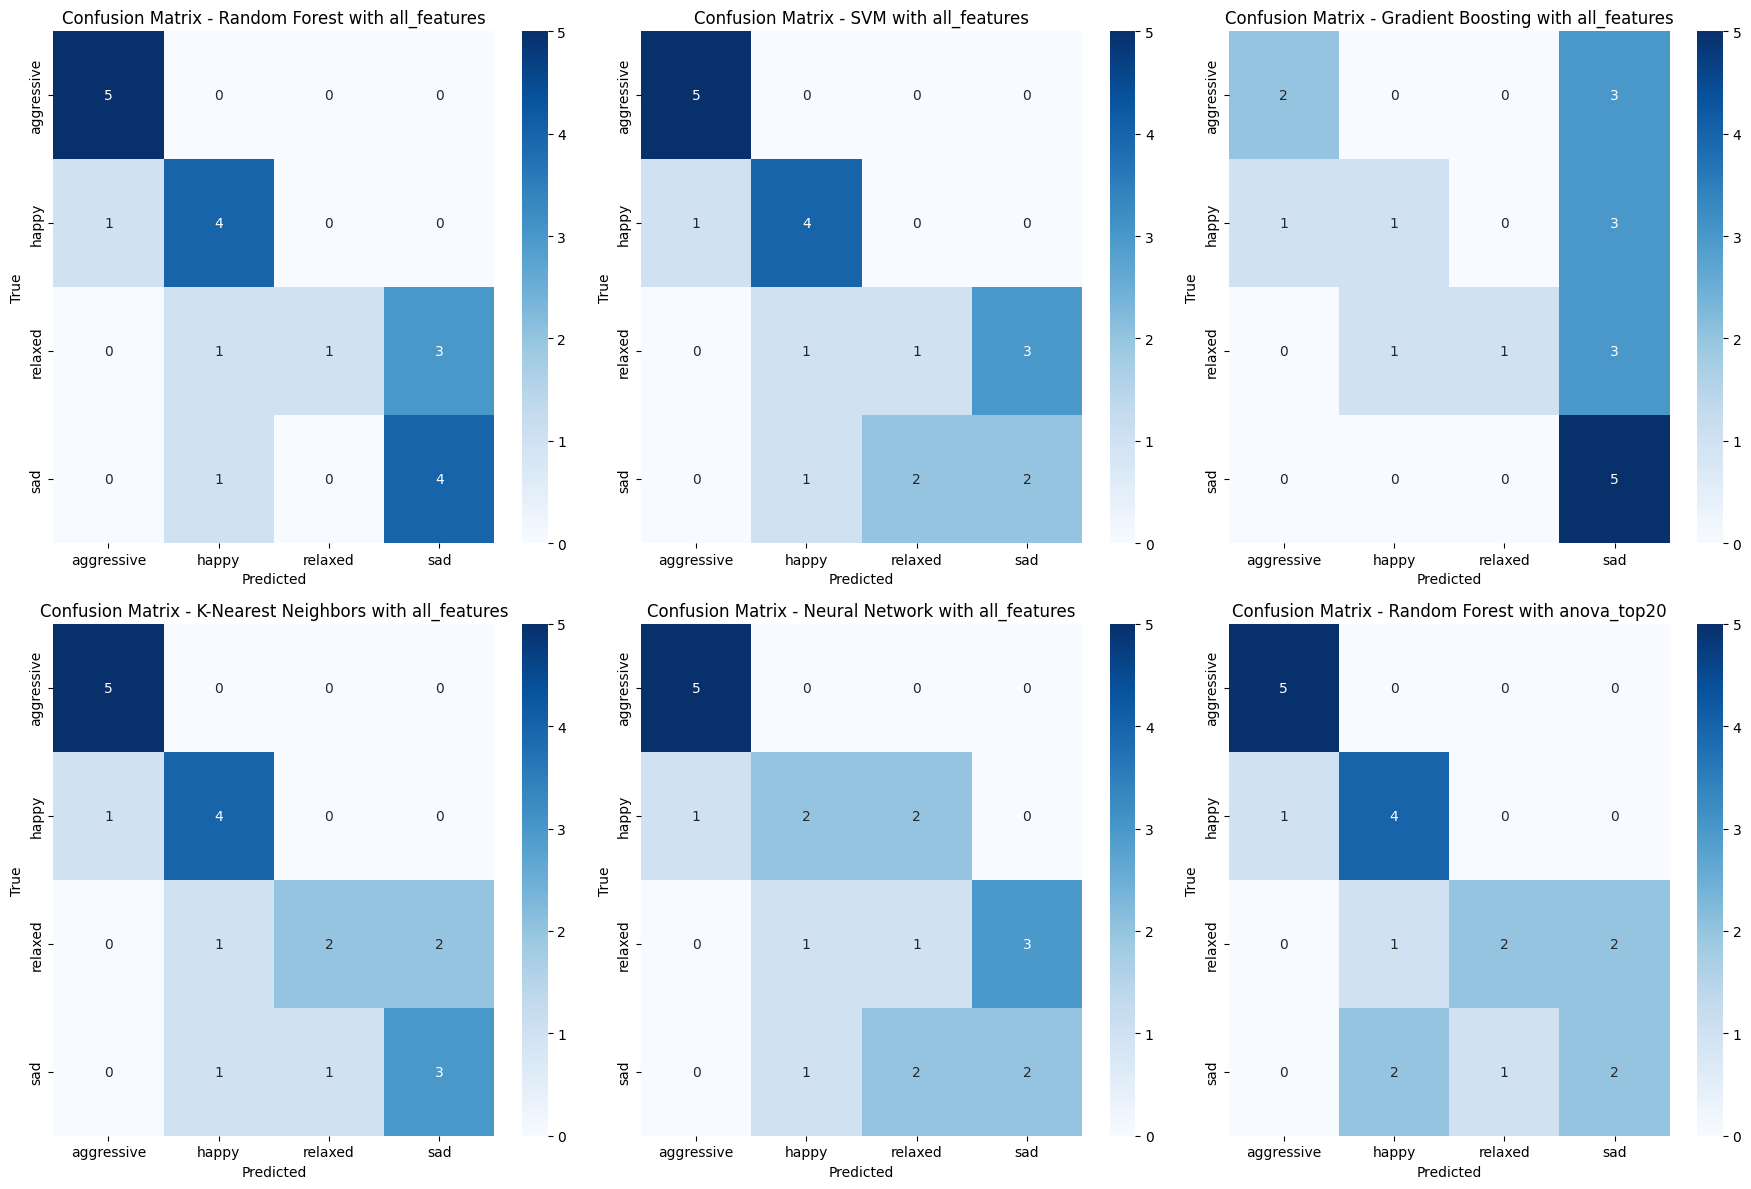


=== SVM with anova_top20 ===
Test Accuracy: 0.7000

Classification Report:
              precision    recall  f1-score   support

  aggressive       1.00      1.00      1.00         5
       happy       0.71      1.00      0.83         5
     relaxed       0.67      0.40      0.50         5
         sad       0.40      0.40      0.40         5

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.68        20
weighted avg       0.70      0.70      0.68        20


=== Gradient Boosting with anova_top20 ===
Test Accuracy: 0.4000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.67      0.40      0.50         5
       happy       0.40      0.40      0.40         5
     relaxed       0.50      0.60      0.55         5
         sad       0.17      0.20      0.18         5

    accuracy                           0.40        20
   macro avg       0.43      0.40      0.41        20
weighted avg       

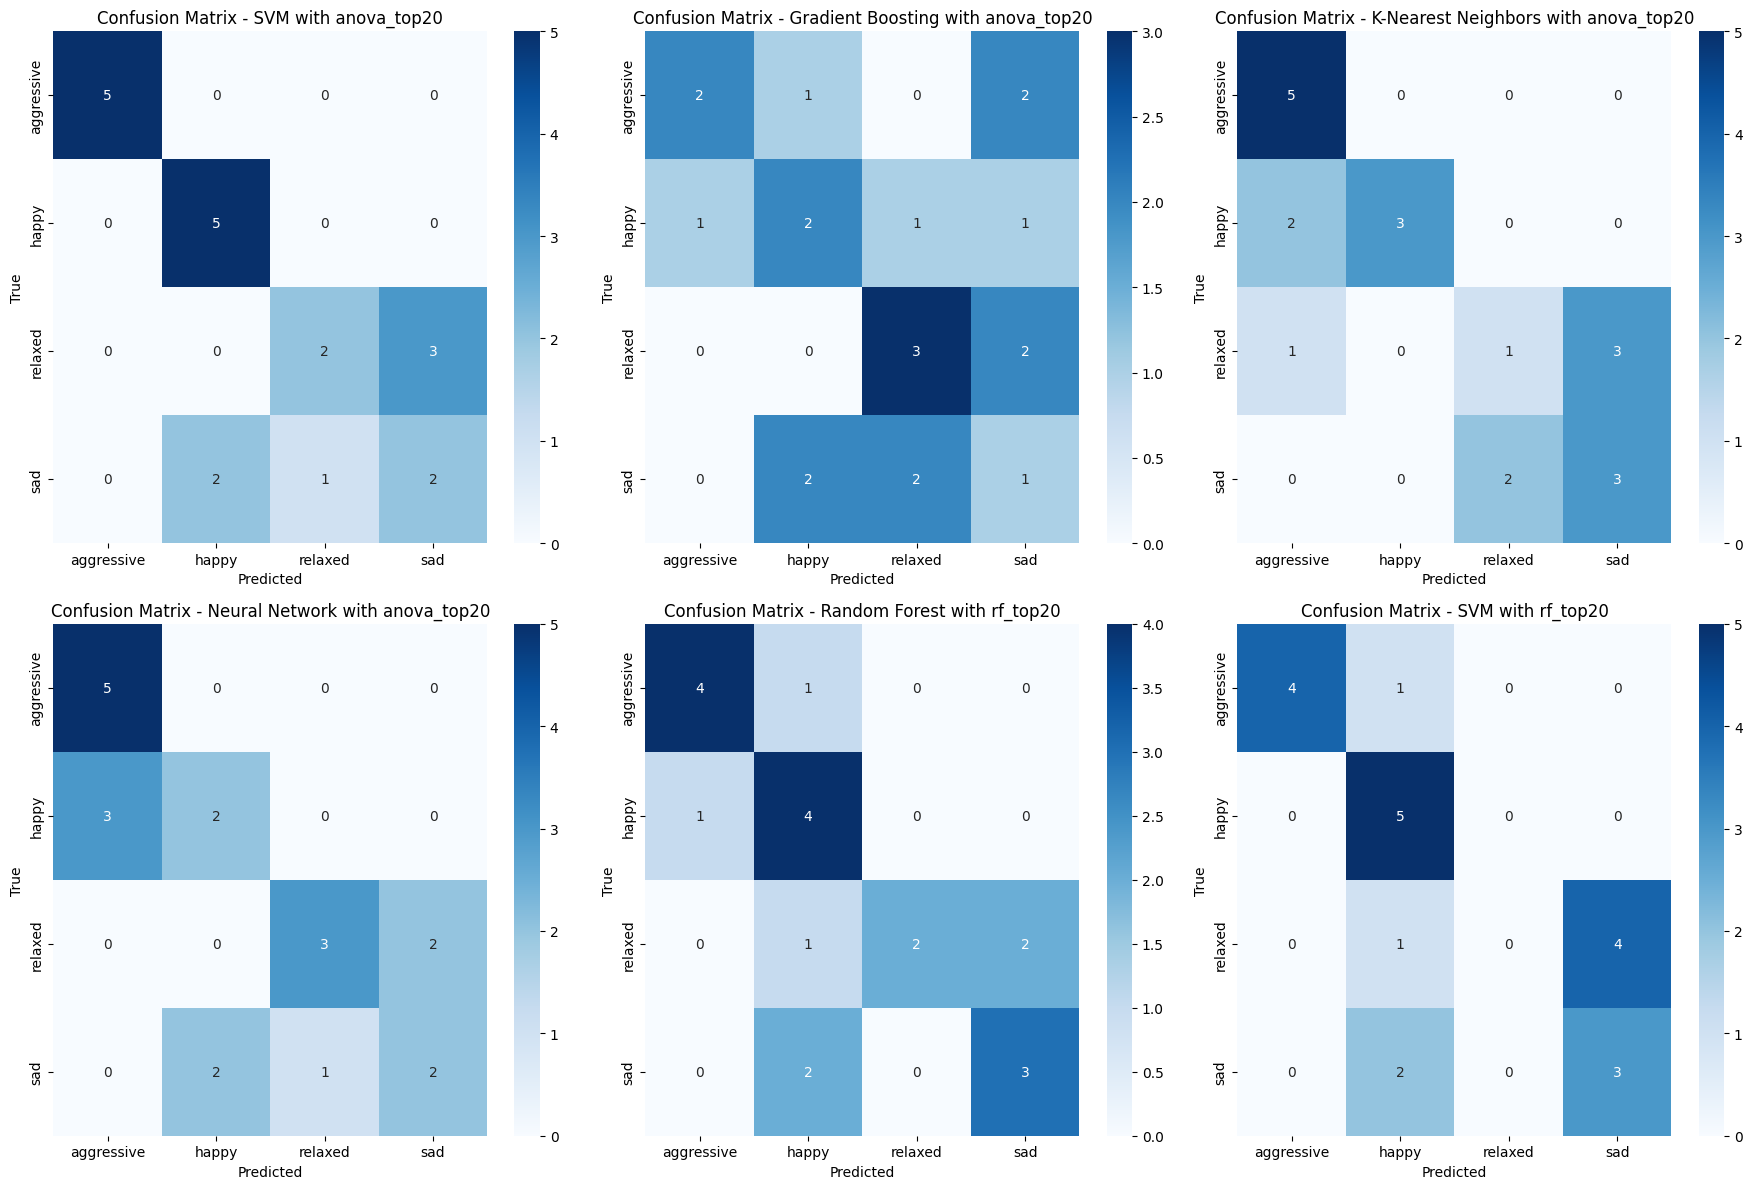


=== Gradient Boosting with rf_top20 ===
Test Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

  aggressive       1.00      0.60      0.75         5
       happy       0.43      0.60      0.50         5
     relaxed       0.75      0.60      0.67         5
         sad       0.50      0.60      0.55         5

    accuracy                           0.60        20
   macro avg       0.67      0.60      0.62        20
weighted avg       0.67      0.60      0.62        20


=== K-Nearest Neighbors with rf_top20 ===
Test Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.80      0.80      0.80         5
       happy       0.50      0.60      0.55         5
     relaxed       0.67      0.40      0.50         5
         sad       0.50      0.60      0.55         5

    accuracy                           0.60        20
   macro avg       0.62      0.60      0.60        20
weighted 

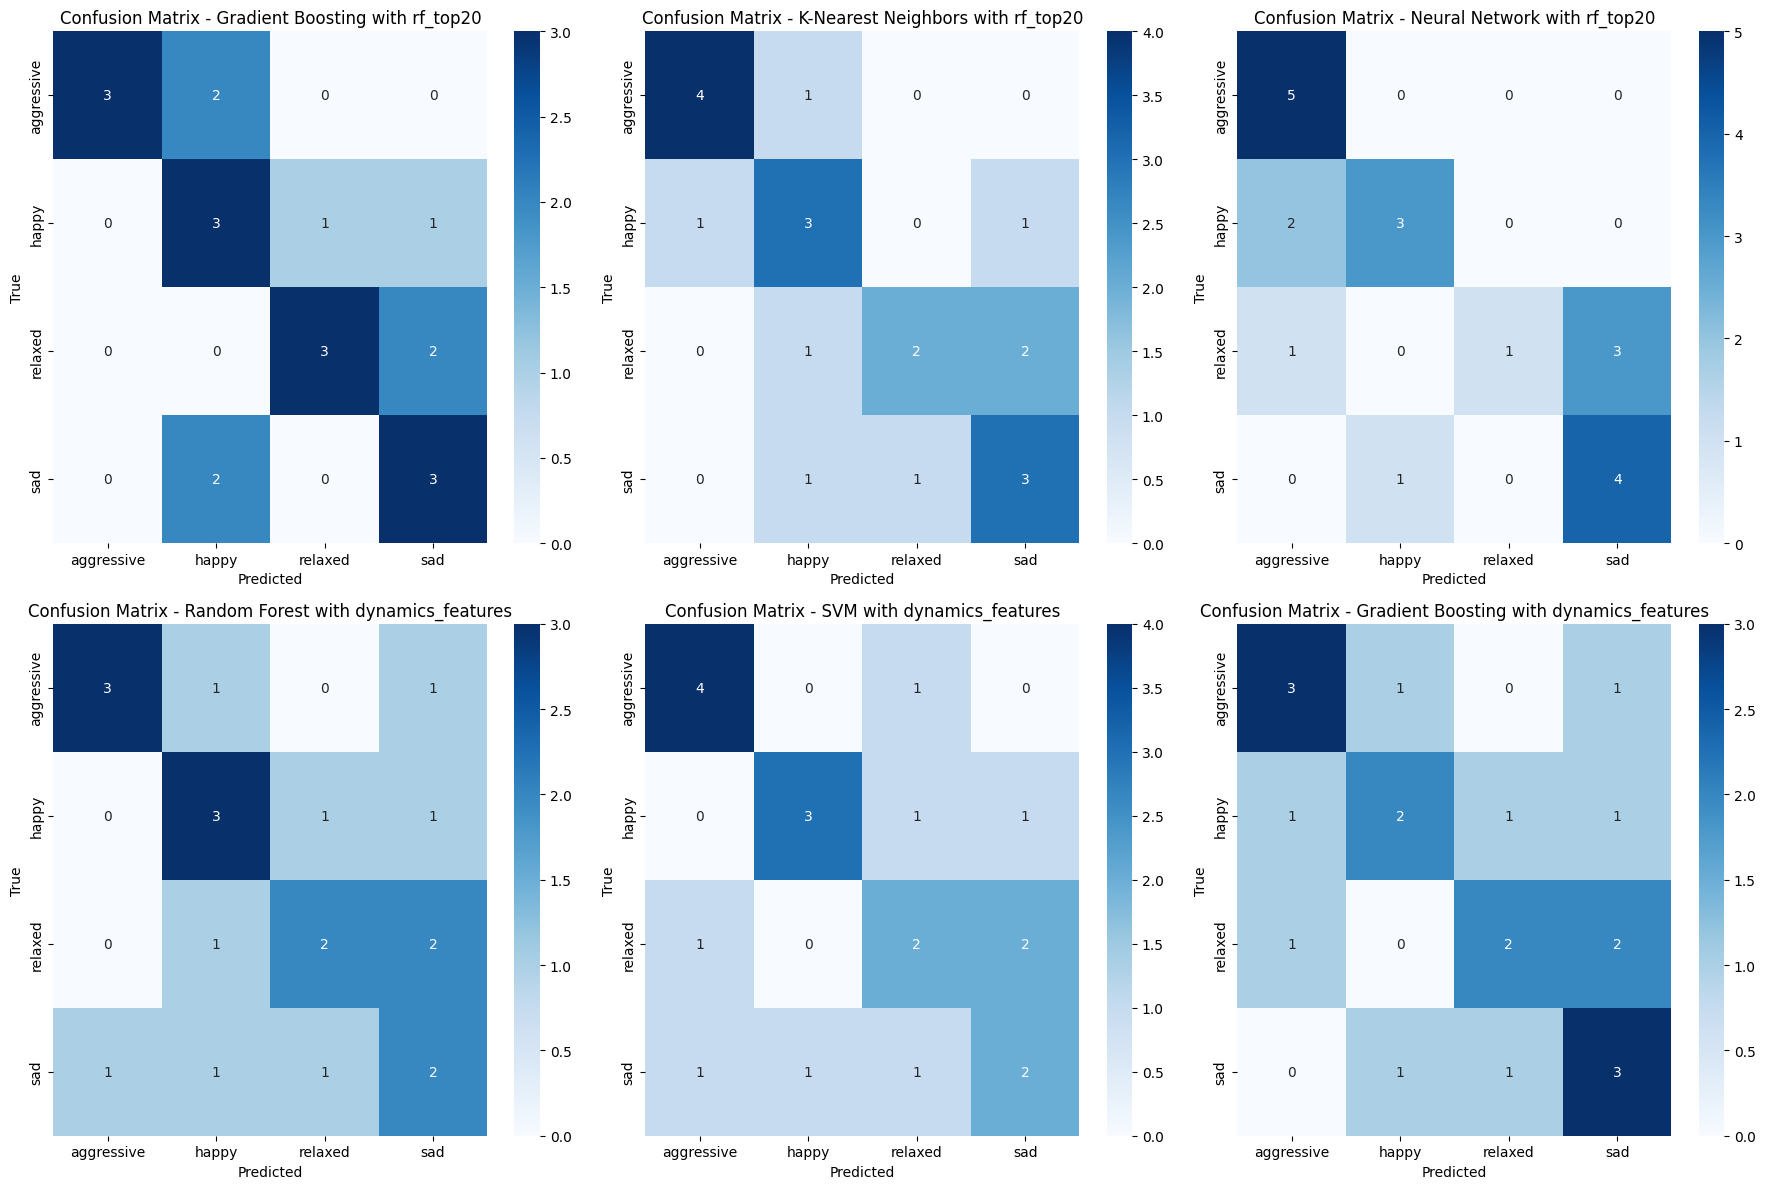


=== K-Nearest Neighbors with dynamics_features ===
Test Accuracy: 0.4500

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.60      0.60      0.60         5
       happy       0.50      0.60      0.55         5
     relaxed       0.25      0.20      0.22         5
         sad       0.40      0.40      0.40         5

    accuracy                           0.45        20
   macro avg       0.44      0.45      0.44        20
weighted avg       0.44      0.45      0.44        20


=== Neural Network with dynamics_features ===
Test Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.67      0.80      0.73         5
       happy       1.00      0.60      0.75         5
     relaxed       0.43      0.60      0.50         5
         sad       0.50      0.40      0.44         5

    accuracy                           0.60        20
   macro avg       0.65      0.60      0.61     

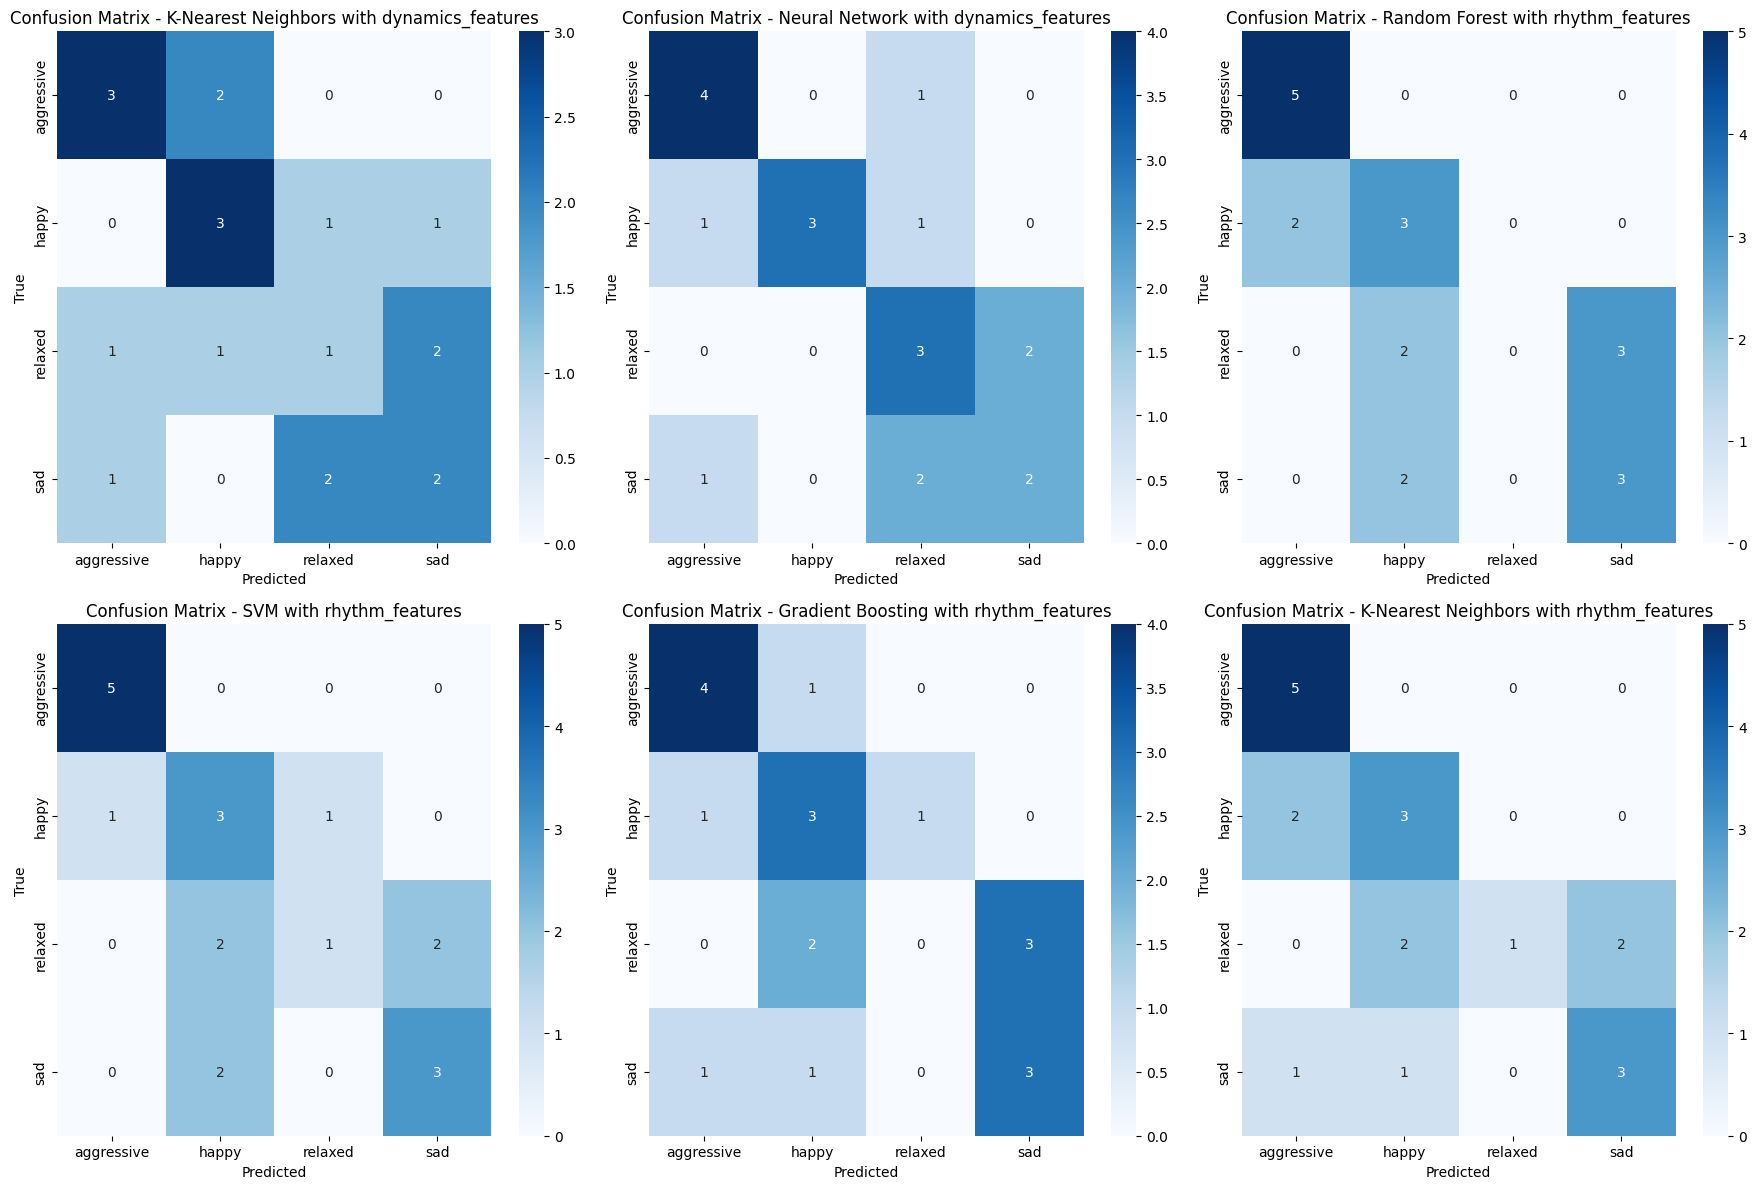


=== Neural Network with rhythm_features ===
Test Accuracy: 0.5500

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.67      0.80      0.73         5
       happy       0.38      0.60      0.46         5
     relaxed       1.00      0.20      0.33         5
         sad       0.60      0.60      0.60         5

    accuracy                           0.55        20
   macro avg       0.66      0.55      0.53        20
weighted avg       0.66      0.55      0.53        20



=== Feature Set: pitch_features (6 features) ===

=== Random Forest with pitch_features ===
Test Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.62      1.00      0.77         5
       happy       1.00      0.20      0.33         5
     relaxed       0.33      0.40      0.36         5
         sad       0.40      0.40      0.40         5

    accuracy                           0.50        20
   macro

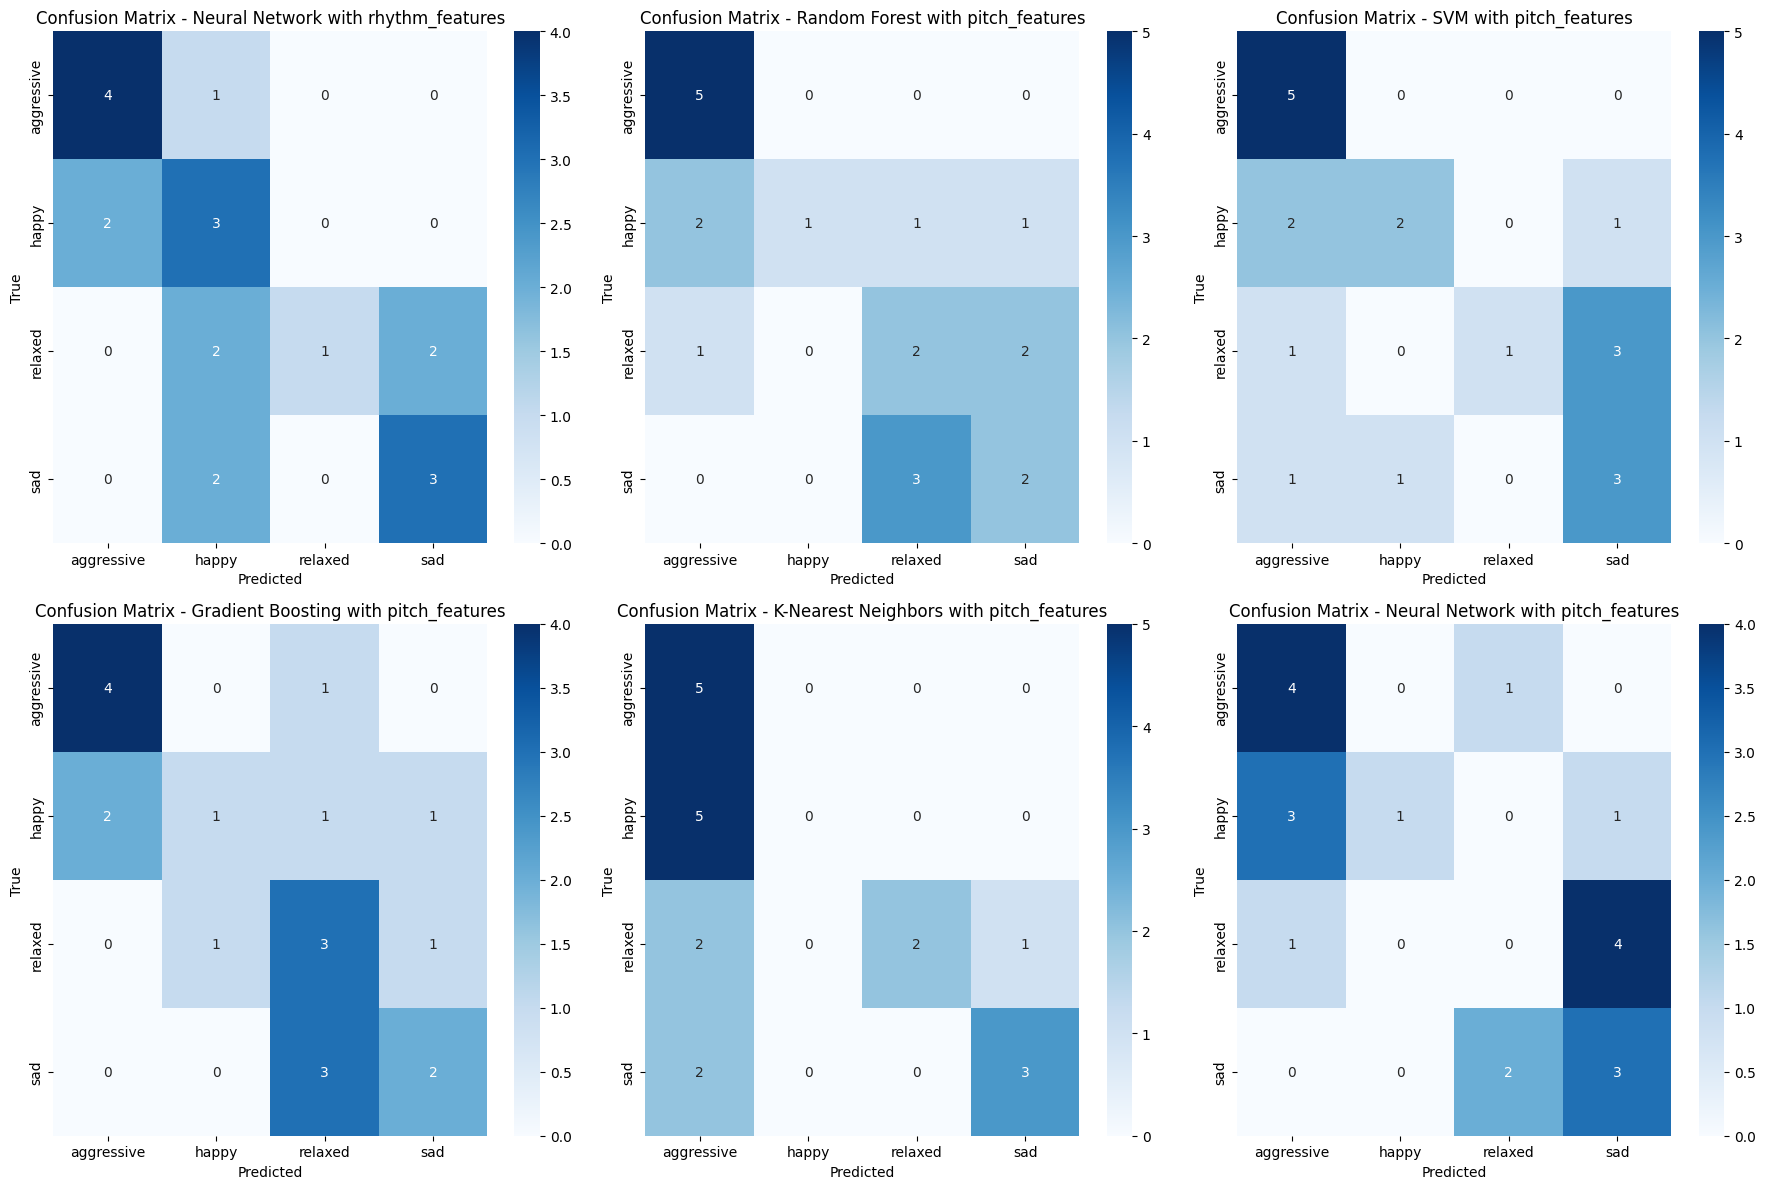



=== Feature Set: harmony_features (9 features) ===

=== Random Forest with harmony_features ===
Test Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.62      1.00      0.77         5
       happy       1.00      0.40      0.57         5
     relaxed       0.40      0.40      0.40         5
         sad       0.20      0.20      0.20         5

    accuracy                           0.50        20
   macro avg       0.56      0.50      0.49        20
weighted avg       0.56      0.50      0.49        20


=== SVM with harmony_features ===
Test Accuracy: 0.5500

Classification Report:
              precision    recall  f1-score   support

  aggressive       1.00      0.60      0.75         5
       happy       0.50      0.60      0.55         5
     relaxed       0.50      0.40      0.44         5
         sad       0.43      0.60      0.50         5

    accuracy                           0.55        20
   macro avg  

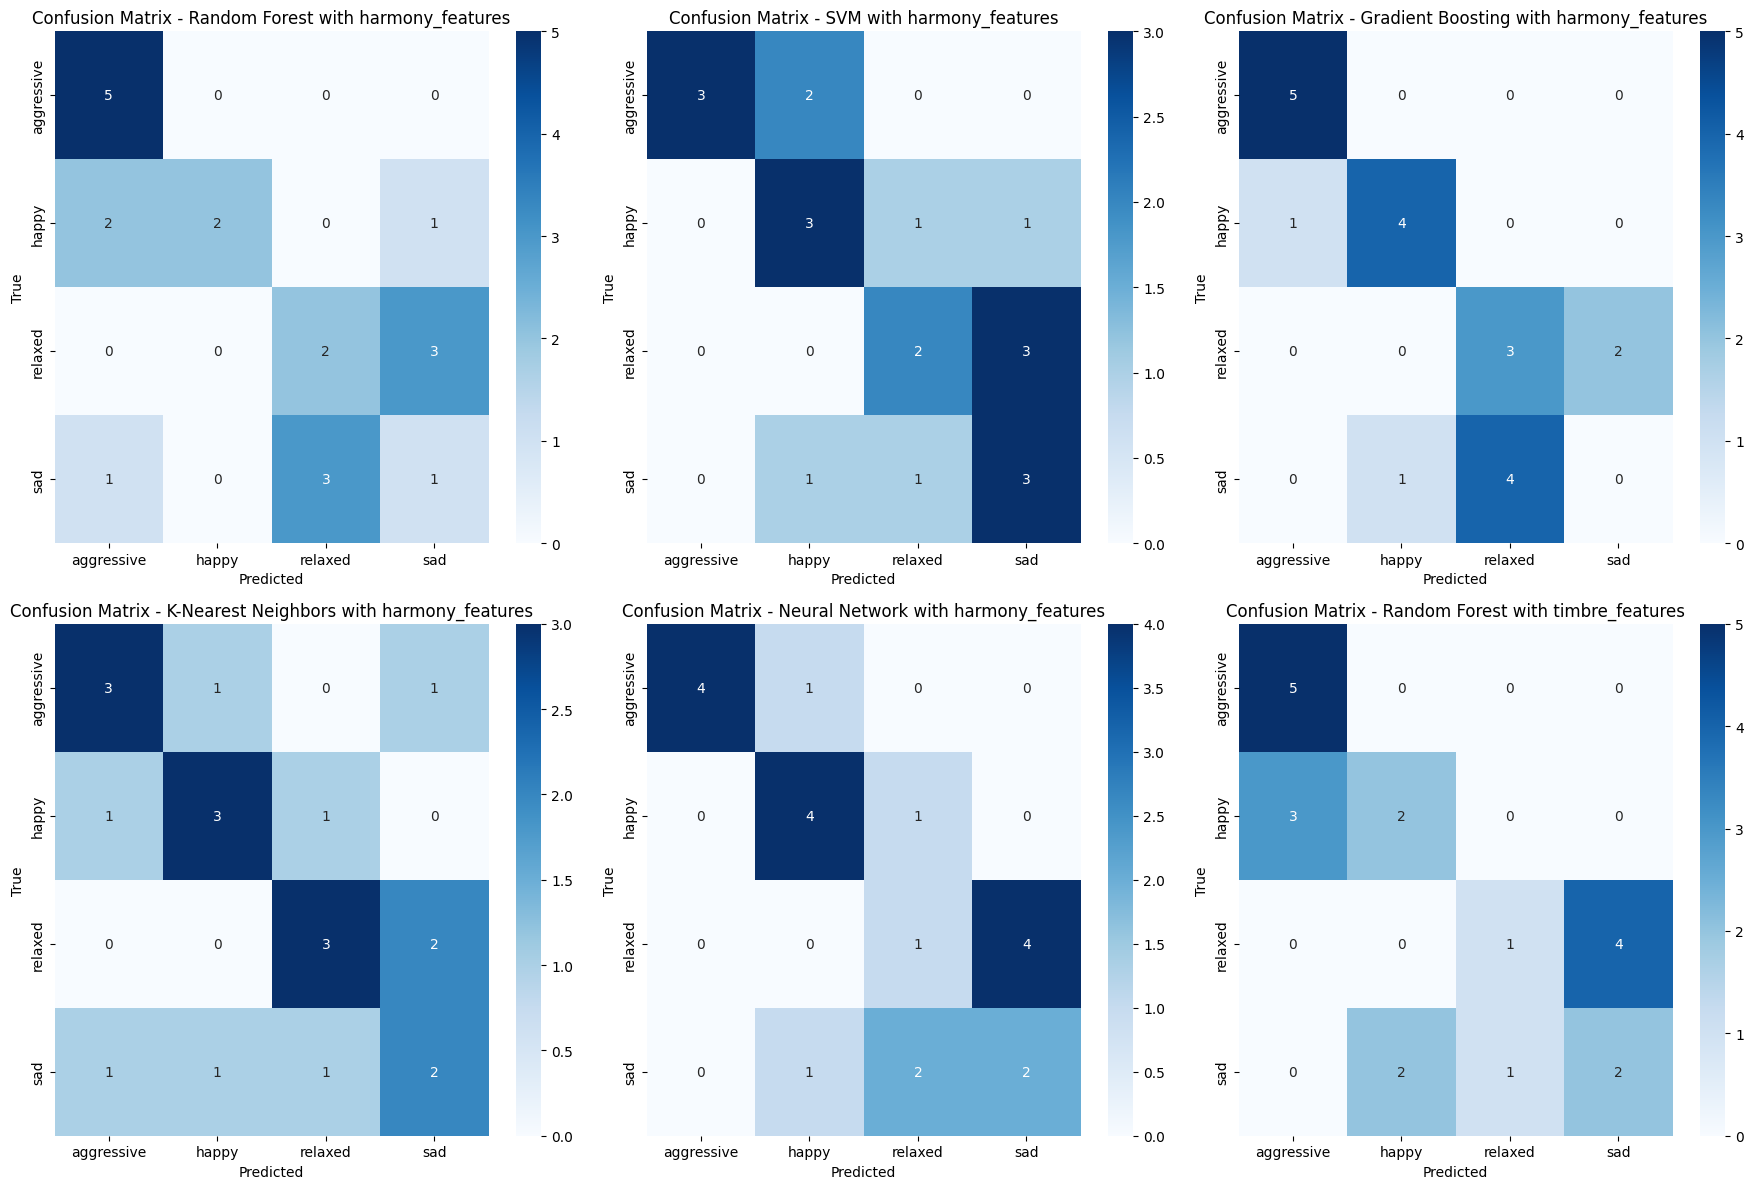


=== SVM with timbre_features ===
Test Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.71      1.00      0.83         5
       happy       0.50      0.40      0.44         5
     relaxed       0.50      0.20      0.29         5
         sad       0.29      0.40      0.33         5

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.47        20
weighted avg       0.50      0.50      0.47        20


=== Gradient Boosting with timbre_features ===
Test Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.67      0.80      0.73         5
       happy       0.67      0.40      0.50         5
     relaxed       0.50      0.20      0.29         5
         sad       0.33      0.60      0.43         5

    accuracy                           0.50        20
   macro avg       0.54      0.50      0.49        20
weighted av

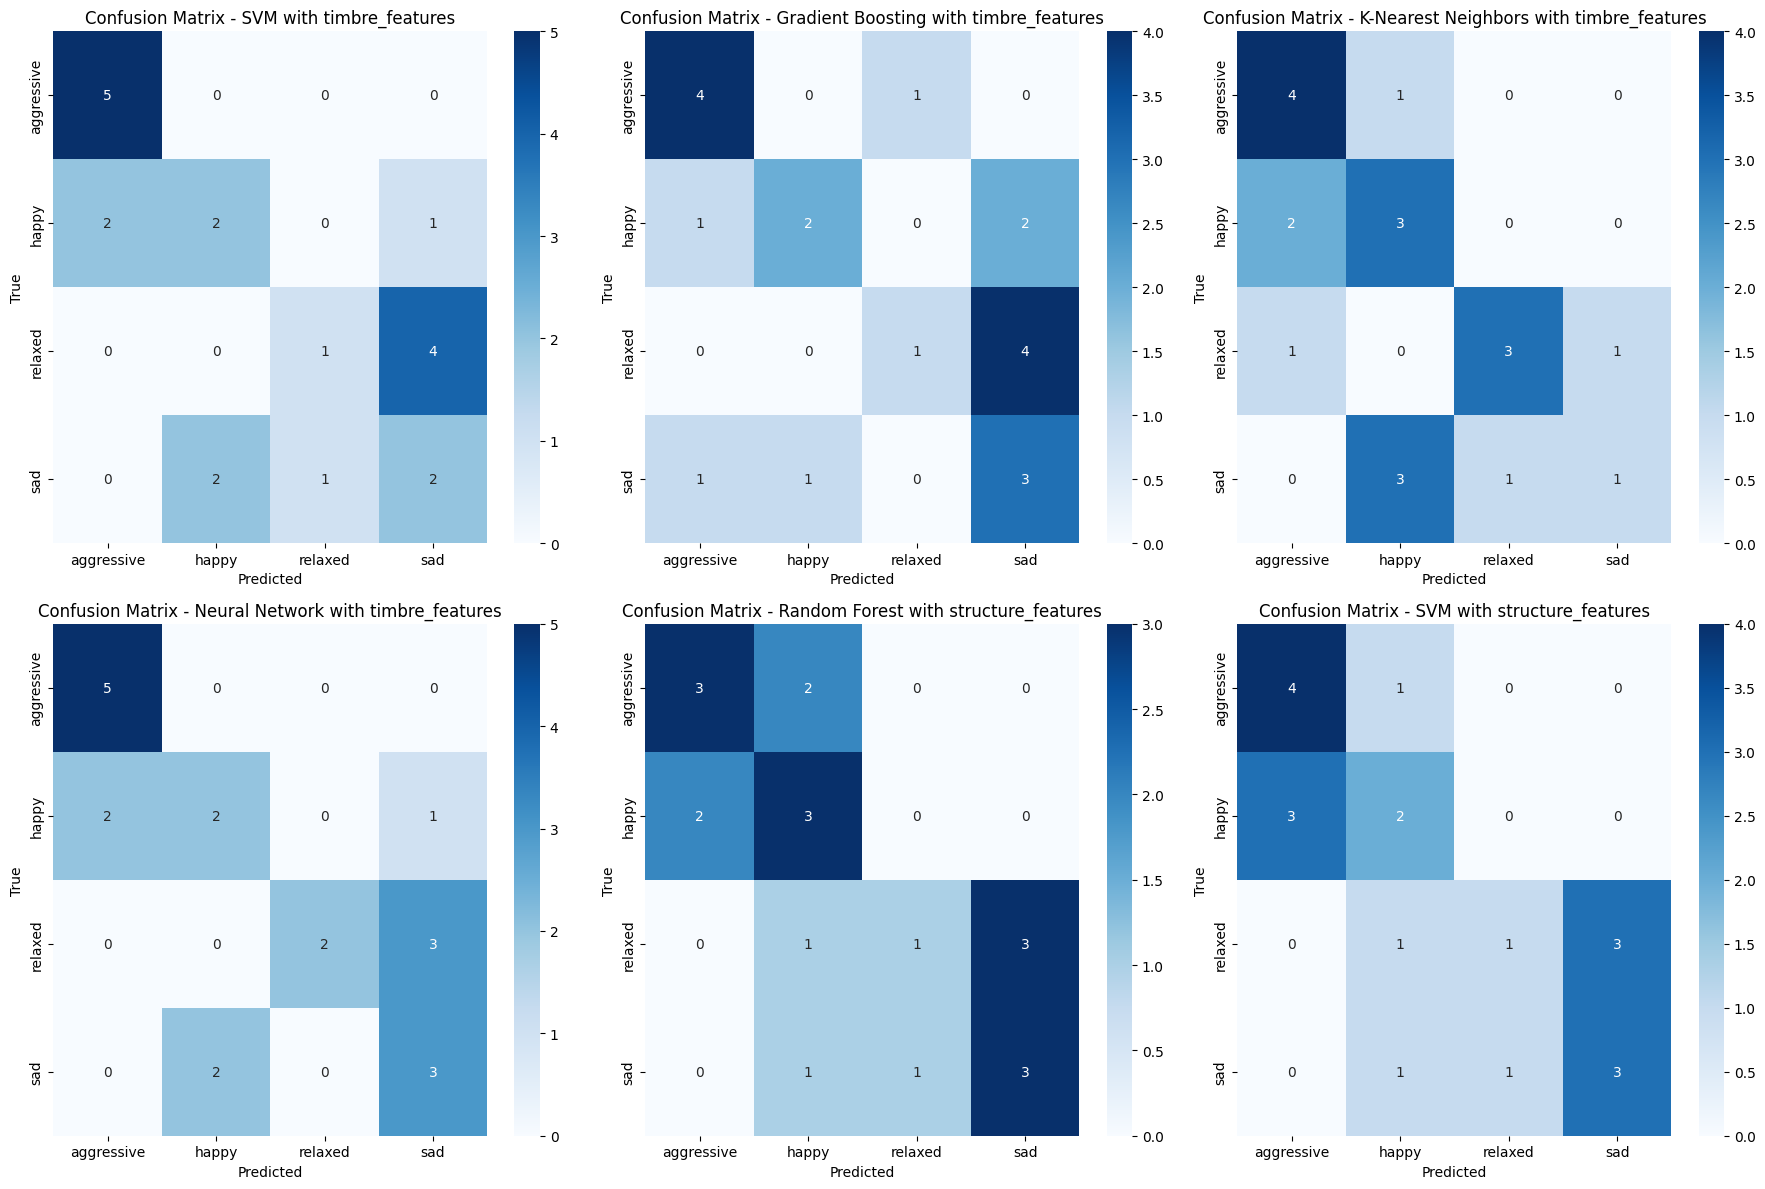


=== Gradient Boosting with structure_features ===
Test Accuracy: 0.4500

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.40      0.40      0.40         5
       happy       0.50      0.60      0.55         5
     relaxed       0.33      0.20      0.25         5
         sad       0.50      0.60      0.55         5

    accuracy                           0.45        20
   macro avg       0.43      0.45      0.44        20
weighted avg       0.43      0.45      0.44        20


=== K-Nearest Neighbors with structure_features ===
Test Accuracy: 0.6500

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.67      0.80      0.73         5
       happy       0.67      0.80      0.73         5
     relaxed       0.67      0.40      0.50         5
         sad       0.60      0.60      0.60         5

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.64

In [13]:
# Store results for comparison
results = []

# Try different combinations of models and feature sets
for feature_set_name, features in feature_sets.items():
    print(f"\n\n=== Feature Set: {feature_set_name} ({len(features)} features) ===")

    # Validate features first
    valid_features = [f for f in features if f in X_train_scaled_df.columns]
    invalid_features = [f for f in features if f not in X_train_scaled_df.columns]

    if invalid_features:
        print(
            f"Warning: Skipping {len(invalid_features)} invalid features: {invalid_features}"
        )
        if not valid_features:
            print(f"Skipping {feature_set_name} entirely as no valid features remain")
            continue

    # Extract these features from our data
    X_train_set = X_train_scaled_df[valid_features]
    X_test_set = X_test_scaled_df[valid_features]

    for model_name, model in models.items():
        try:
            accuracy, _ = evaluate_model(
                model,
                X_train_set,
                y_train,
                X_test_set,
                y_test,
                model_name=f"{model_name} with {feature_set_name}",
            )

            results.append(
                {
                    "Model": model_name,
                    "Feature Set": feature_set_name,
                    "Number of Features": len(valid_features),
                    "Accuracy": accuracy,
                }
            )
        except Exception as e:
            print(f"Error training {model_name} with {feature_set_name}: {str(e)}")
            # Continue with next model

In [14]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print("\n=== Overall Model Comparison ===")
print(results_df.sort_values("Accuracy", ascending=False))


=== Overall Model Comparison ===
                  Model         Feature Set  Number of Features  Accuracy
0         Random Forest        all_features                  66      0.70
3   K-Nearest Neighbors        all_features                  66      0.70
6                   SVM         anova_top20                  20      0.70
43  K-Nearest Neighbors  structure_features                   8      0.65
5         Random Forest         anova_top20                  20      0.65
10        Random Forest            rf_top20                  20      0.65
14       Neural Network            rf_top20                  20      0.65
13  K-Nearest Neighbors            rf_top20                  20      0.60
1                   SVM        all_features                  66      0.60
21                  SVM     rhythm_features                   8      0.60
19       Neural Network   dynamics_features                   6      0.60
32    Gradient Boosting    harmony_features                   9      0.60
12  

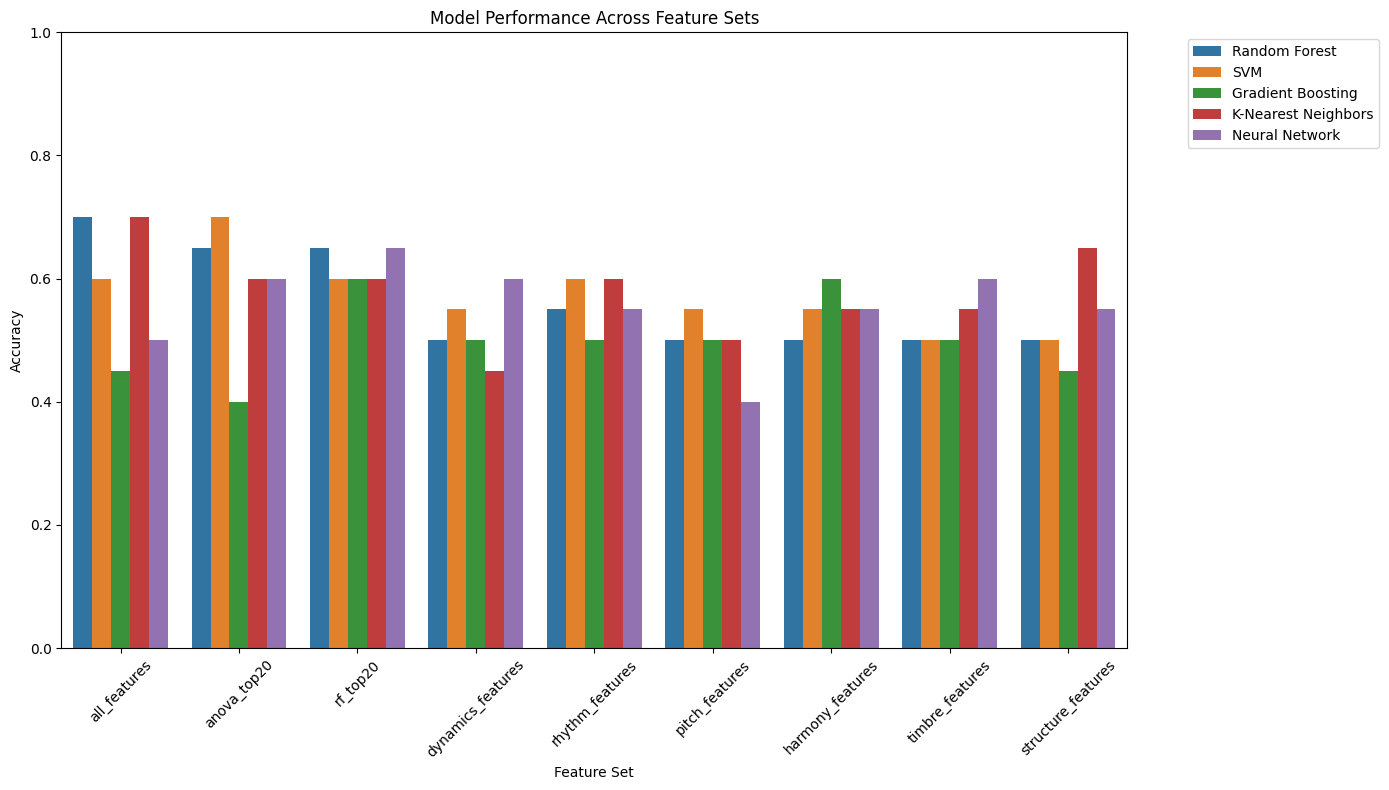

In [15]:
# Visualize model performance across feature sets
plt.figure(figsize=(14, 8))
sns.barplot(x="Feature Set", y="Accuracy", hue="Model", data=results_df)
plt.title("Model Performance Across Feature Sets")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 7. Hyperparameter Tuning for Best Model

In [16]:
# use IQR method to detect outliers
print("\n=== Outlier Detection and Handling ===")


def detect_and_handle_outliers(X_train_df, X_test_df, method="clip"):
    """
    Detect and handle outliers in the dataset

    Parameters:
    - X_train_df: Training features DataFrame
    - X_test_df: Test features DataFrame
    - method: 'clip' or 'remove' outliers

    Returns:
    - Processed X_train_df and X_test_df
    """
    # Copy the dataframes to avoid modifying the originals
    X_train_processed = X_train_df.copy()
    X_test_processed = X_test_df.copy()

    outliers_summary = {}

    # Detect and handle outliers feature by feature
    for feature in X_train_df.columns:
        # Calculate IQR
        Q1 = X_train_df[feature].quantile(0.25)
        Q3 = X_train_df[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers_count = (
            (X_train_df[feature] < lower_bound) | (X_train_df[feature] > upper_bound)
        ).sum()

        outliers_summary[feature] = outliers_count

        if method == "clip":
            # Clip values outside the bounds
            X_train_processed[feature] = X_train_processed[feature].clip(
                lower_bound, upper_bound
            )
            X_test_processed[feature] = X_test_processed[feature].clip(
                lower_bound, upper_bound
            )

    # Sort and print features by outlier count
    sorted_outliers = sorted(outliers_summary.items(), key=lambda x: x[1], reverse=True)
    print("Features with most outliers:")
    for feature, count in sorted_outliers[:10]:  # Show top 10
        if count > 0:
            print(f"  {feature}: {count} outliers")

    return X_train_processed, X_test_processed


# Handle outliers
X_train_scaled_df_no_outliers, X_test_scaled_df_no_outliers = (
    detect_and_handle_outliers(X_train_scaled_df, X_test_scaled_df, method="clip")
)

# Use the outlier-handled data for the best model
X_train_scaled_df = X_train_scaled_df_no_outliers
X_test_scaled_df = X_test_scaled_df_no_outliers

# Identify best model and feature set combination
best_result = results_df.sort_values("Accuracy", ascending=False).iloc[0]
best_model_name = best_result["Model"]
best_feature_set = best_result["Feature Set"]


=== Outlier Detection and Handling ===
Features with most outliers:
  Pd: 5 outliers
  Im: 5 outliers
  Id: 5 outliers
  M2m: 5 outliers
  ATm: 4 outliers
  FMm: 4 outliers
  ESm: 4 outliers
  M4m: 4 outliers
  El: 3 outliers
  Asm: 3 outliers


In [17]:
print(f"\n=== Hyperparameter Tuning for {best_model_name} with {best_feature_set} ===")

# Get the features for the best feature set
best_features = feature_sets[best_feature_set]
X_train_best = X_train_scaled_df[best_features]
X_test_best = X_test_scaled_df[best_features]

# Define hyperparameter grids for different models
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto", 0.01, 0.1, 1],
        "kernel": ["rbf", "linear", "poly"],
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2],
    },
    "Neural Network": {
        "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
        "activation": ["relu", "tanh"],
        "alpha": [0.0001, 0.001, 0.01],
        "learning_rate": ["constant", "adaptive"],
    },
}

# Get the right model and parameter grid
best_model = models[best_model_name]
param_grid = param_grids[best_model_name]


=== Hyperparameter Tuning for Random Forest with all_features ===


In [18]:
# Create grid search with cross-validation
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# Fit grid search
grid_search.fit(X_train_best, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate model with best parameters
best_tuned_model = grid_search.best_estimator_
accuracy, y_pred_best = evaluate_model(
    best_tuned_model,
    X_train_best,
    y_train,
    X_test_best,
    y_test,
    model_name=f"Tuned {best_model_name} with {best_feature_set}",
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.7666666666666667

=== Tuned Random Forest with all_features ===
Test Accuracy: 0.7000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.83      1.00      0.91         5
       happy       0.67      0.80      0.73         5
     relaxed       0.67      0.40      0.50         5
         sad       0.60      0.60      0.60         5

    accuracy                           0.70        20
   macro avg       0.69      0.70      0.68        20
weighted avg       0.69      0.70      0.68        20



### 8. Error Analysis


=== Misclassified Samples ===
                                     File_Name    class   Predicted
5   02-baby_i_ve_got_you_on_my_mind.mp3           happy  aggressive
10        01-snow_falls_in_november.mp3         relaxed         sad
12                   01-st._stephen.mp3         relaxed         sad
14                  01-treat_u_rite.mp3         relaxed       happy
15             02-padraic_my_prince.mp3             sad     relaxed
17          03-ana_s_song_open_fire.mp3             sad       happy


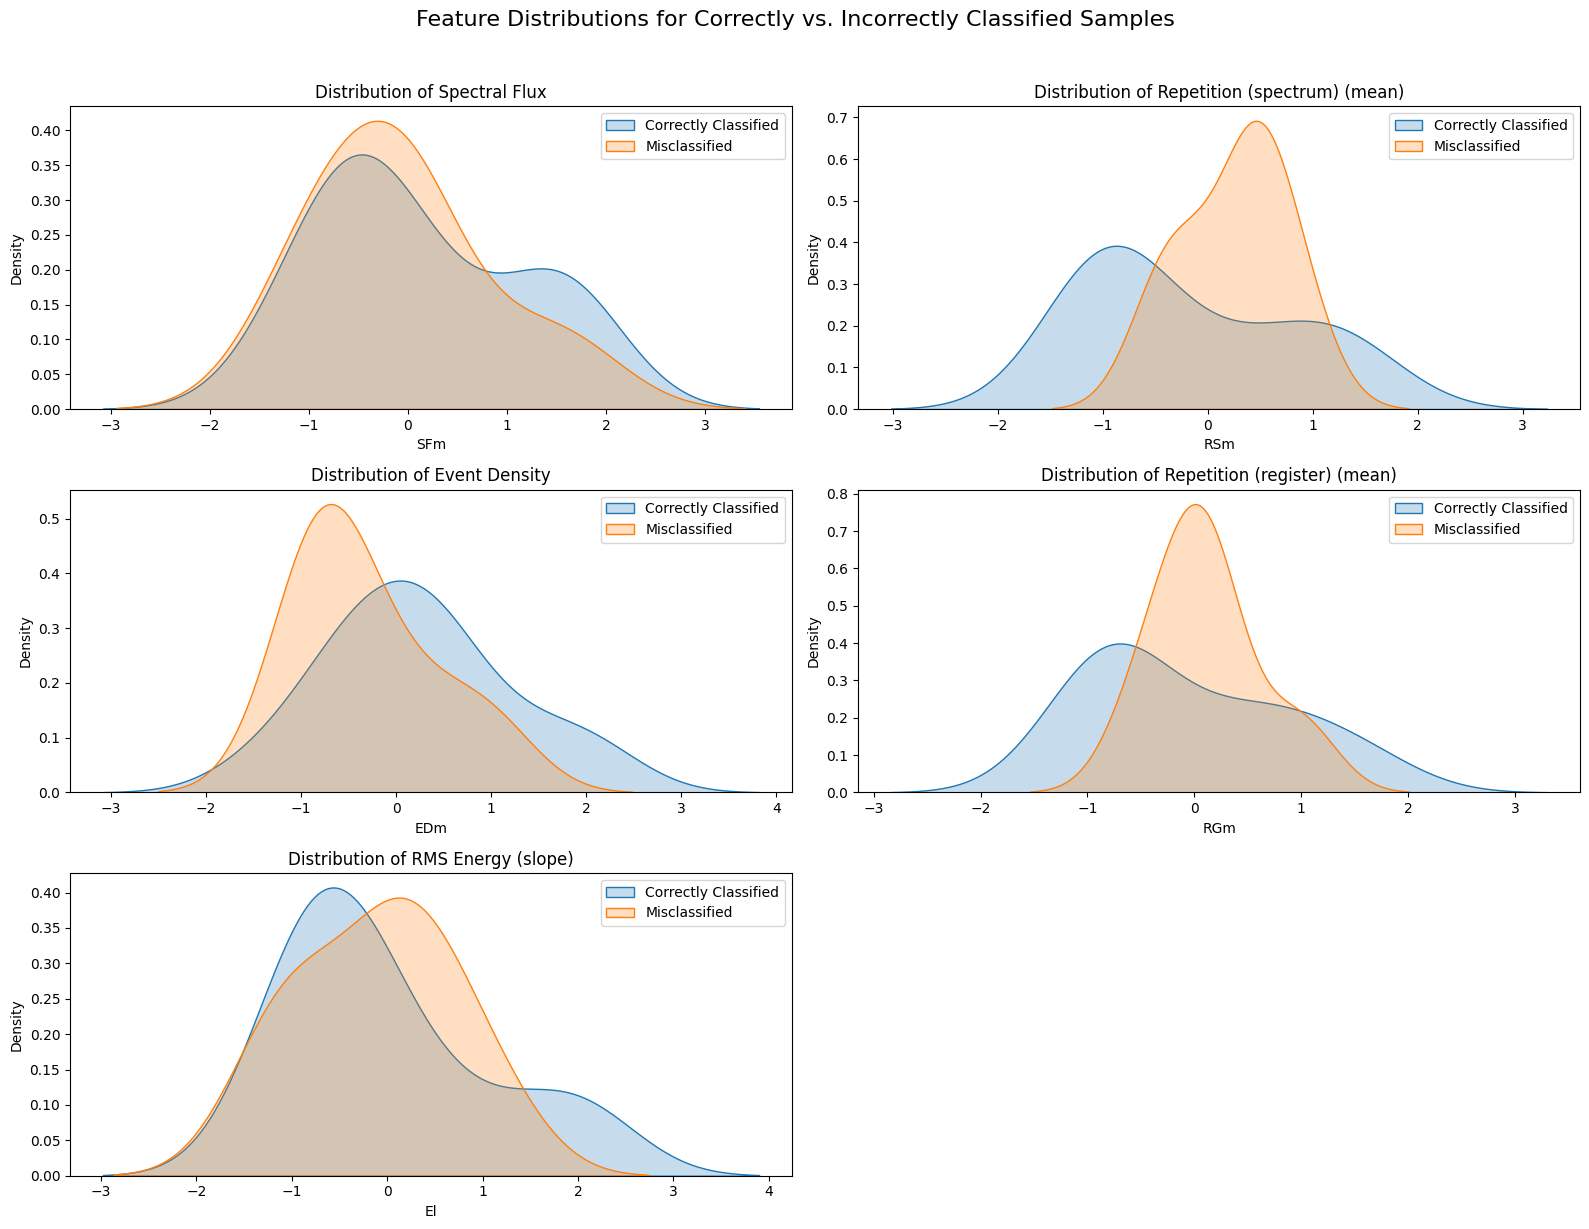

In [19]:
# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred_best)[0]
misclassified_data = test_df.iloc[misclassified_indices].copy()
misclassified_data["Predicted"] = y_pred_best[misclassified_indices]

print("\n=== Misclassified Samples ===")
print(misclassified_data[["File_Name", "class", "Predicted"]])

# Analyze features of misclassified samples
if len(misclassified_indices) > 0:
    # Compare feature distributions of correctly and incorrectly classified samples
    correct_indices = np.where(y_test == y_pred_best)[0]

    X_test_correct = X_test_scaled_df.iloc[correct_indices]
    X_test_incorrect = X_test_scaled_df.iloc[misclassified_indices]

    # Analyze differences in important features
    top_features = rf_importances["Feature"].head(5).tolist()

    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(top_features):
        plt.subplot(3, 2, i + 1)

        # Get full feature name for the title
        feature_full_name = get_full_feature_name(feature)

        # Plot correct vs. incorrect distributions
        sns.kdeplot(X_test_correct[feature], label="Correctly Classified", shade=True)
        sns.kdeplot(X_test_incorrect[feature], label="Misclassified", shade=True)

        plt.title(f"Distribution of {feature_full_name}", fontsize=12)
        plt.legend()

    plt.suptitle(
        "Feature Distributions for Correctly vs. Incorrectly Classified Samples",
        fontsize=16,
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

### 9. Final Model and Conclusions


=== Final Model Performance ===
Test Accuracy: 0.7000

Classification Report:
              precision    recall  f1-score   support

  aggressive       0.83      1.00      0.91         5
       happy       0.67      0.80      0.73         5
     relaxed       0.67      0.40      0.50         5
         sad       0.60      0.60      0.60         5

    accuracy                           0.70        20
   macro avg       0.69      0.70      0.68        20
weighted avg       0.69      0.70      0.68        20



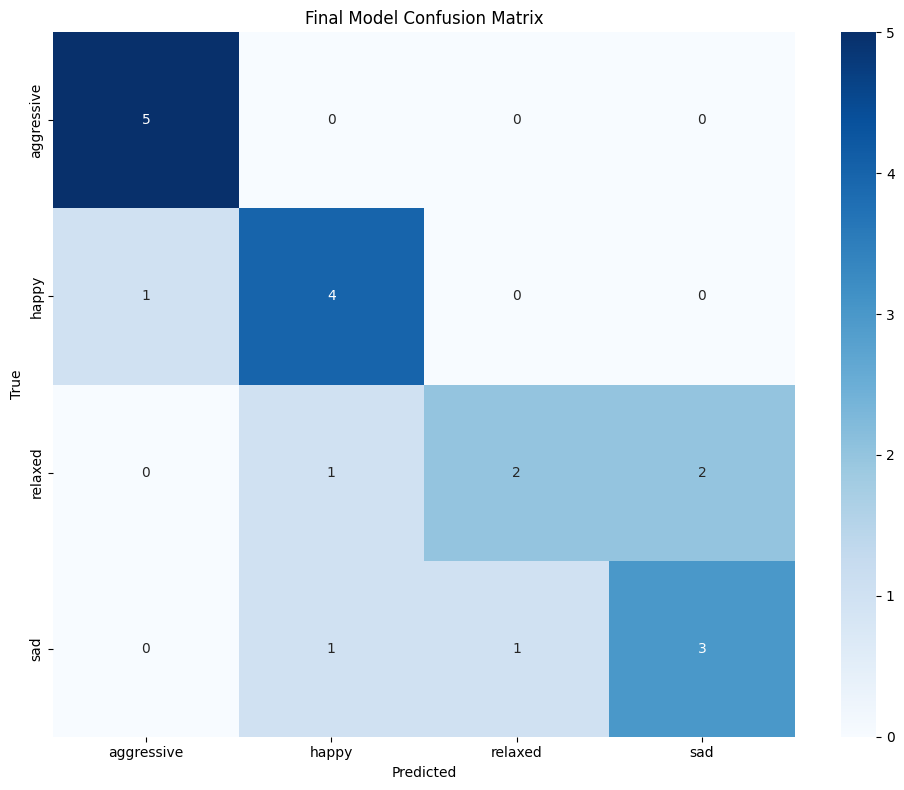

In [20]:
# Train final model on entire training set using best parameters and features
final_model = grid_search.best_estimator_
final_model.fit(X_train_best, y_train)

# Make predictions on test set
final_predictions = final_model.predict(X_test_best)
final_accuracy = accuracy_score(y_test, final_predictions)

print("\n=== Final Model Performance ===")
print(f"Test Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_predictions))

# Final confusion matrix
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)
plt.title("Final Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


=== Feature Importance by Category ===
timbre: 0.3397
structure: 0.2265
rhythm: 0.1384
harmony: 0.1203
dynamics: 0.1089
pitch: 0.0409


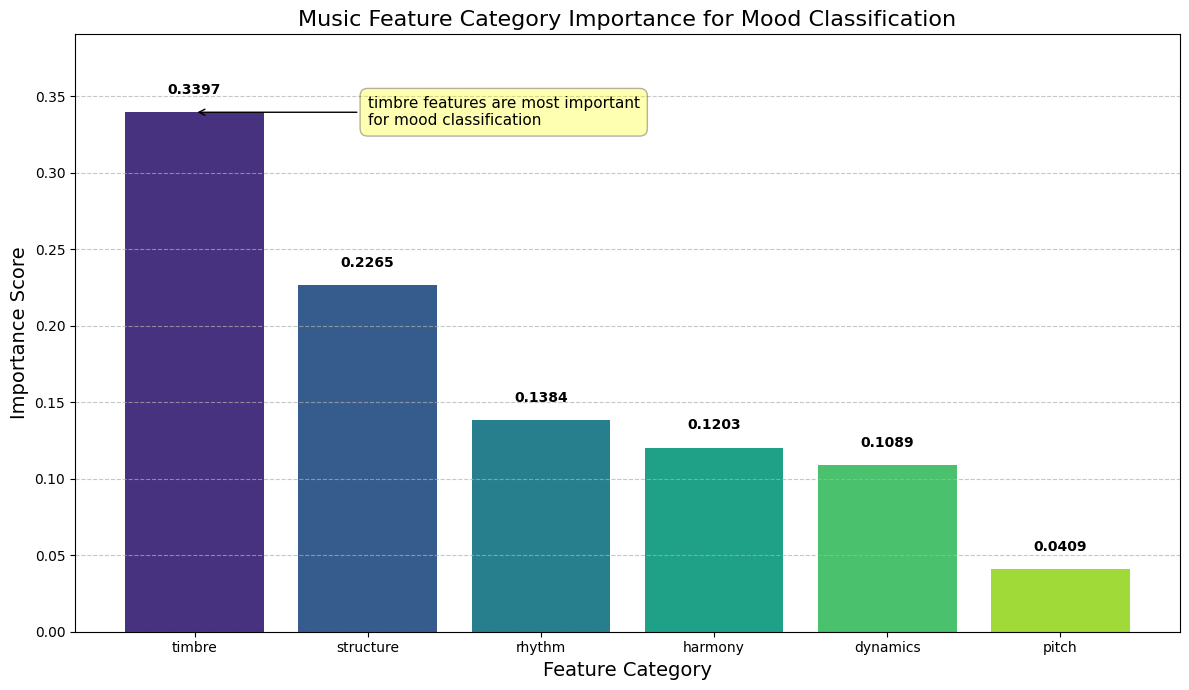

In [21]:
# Summary of feature importance by category
print("\n=== Feature Importance by Category ===")
for category, importance in sorted(
    category_importance.items(), key=lambda x: x[1], reverse=True
):
    print(f"{category}: {importance:.4f}")


# Plot feature importance by category
def plot_feature_importance_by_category(category_importance):
    # Sort categories by importance
    categories = []
    importances = []

    for category, importance in sorted(
        category_importance.items(), key=lambda x: x[1], reverse=True
    ):
        categories.append(category)
        importances.append(importance)

    # Create the plot with a colorful palette
    plt.figure(figsize=(12, 7))
    bars = plt.bar(
        categories, importances, color=sns.color_palette("viridis", len(categories))
    )

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.title("Music Feature Category Importance for Mood Classification", fontsize=16)
    plt.xlabel("Feature Category", fontsize=14)
    plt.ylabel("Importance Score", fontsize=14)
    plt.ylim(0, max(importances) * 1.15)  # Add some space for the labels

    # Add a grid for better readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Annotate with insights
    top_category = categories[0]  # Get the category with highest importance
    plt.annotate(
        f"{top_category} features are most important\nfor mood classification",
        xy=(0, importances[0]),
        xytext=(1, importances[0]),
        ha="left",
        va="center",
        fontsize=11,
        arrowprops=dict(arrowstyle="->"),
        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.3),
    )
    plt.tight_layout()
    plt.show()


# Plot the feature importance by category
plot_feature_importance_by_category(category_importance)


=== Top 10 Features in Final Model ===
   Feature                       Feature_Full  Importance
40     SFm                      Spectral Flux    0.054654
7      EDm                      Event Density    0.051463
58     RSm       Repetition (spectrum) (mean)    0.048778
2       El                 RMS Energy (slope)    0.044459
62     RTm       Repetition (tonality) (mean)    0.042872
64     RGm       Repetition (register) (mean)    0.036426
4      ATm                        Attack Time    0.032002
65     RGd  Repetition (register) (deviation)    0.029123
8      FPm        Fluctuation Peak (position)    0.029074
38     SEm            Spectral Entropy (mean)    0.028865


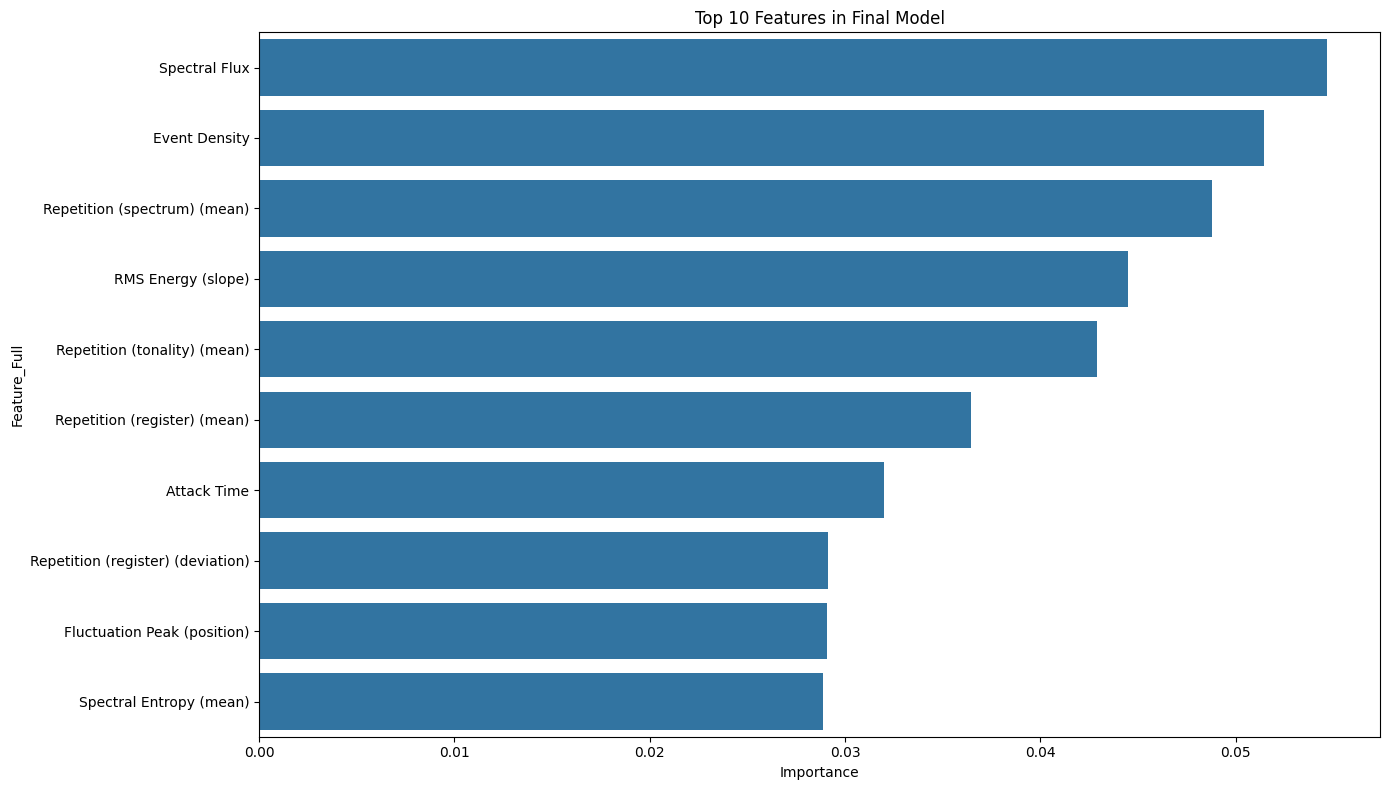

In [22]:
# Print top features from best model
if hasattr(final_model, "feature_importances_"):
    # For tree-based models
    final_importances = pd.DataFrame(
        {"Feature": best_features, "Importance": final_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

    # Add full feature names
    final_importances["Feature_Full"] = final_importances["Feature"].apply(
        get_full_feature_name
    )

    print("\n=== Top 10 Features in Final Model ===")
    print(final_importances[["Feature", "Feature_Full", "Importance"]].head(10))

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Importance", y="Feature_Full", data=final_importances.head(10))
    plt.title("Top 10 Features in Final Model")
    plt.tight_layout()
    plt.show()

### 10. Discussion and Results Summary

In [23]:
# Function to generate results summary programmatically
def generate_results_summary(
    results_df,
    final_model,
    final_predictions,
    y_test,
    feature_importances,
    category_importance,
    missing_values_count,
    outliers_detected,
):
    # Get best model and its details
    best_result = results_df.sort_values("Accuracy", ascending=False).iloc[0]
    best_model_name = best_result["Model"]
    best_feature_set = best_result["Feature Set"]
    best_accuracy = best_result["Accuracy"]

    # Get top features
    if isinstance(feature_importances, pd.DataFrame) and not feature_importances.empty:
        top_features = feature_importances.head(5)
        top_features_str = ", ".join(
            [
                f"{get_full_feature_name(f)} ({i:.4f})"
                for f, i in zip(top_features["Feature"], top_features["Importance"])
            ]
        )
    else:
        top_features_str = "Not available due to model type"

    # Get category importance
    if category_importance:
        # Sort categories by importance
        sorted_categories = sorted(
            category_importance.items(), key=lambda x: x[1], reverse=True
        )
        top_category = sorted_categories[0][0]
        second_category = (
            sorted_categories[1][0] if len(sorted_categories) > 1 else "None"
        )
        least_category = (
            sorted_categories[-1][0] if len(sorted_categories) > 1 else "None"
        )

        # Get full category names
        top_category_full = category_full_names.get(top_category, top_category)
        second_category_full = category_full_names.get(second_category, second_category)
        least_category_full = category_full_names.get(least_category, least_category)
    else:
        top_category_full = "Not available"
        second_category_full = "Not available"
        least_category_full = "Not available"

    # Error analysis
    cm = confusion_matrix(y_test, final_predictions)
    classes = np.unique(y_test)

    # Find the most common misclassifications
    misclassification_counts = {}
    for i in range(len(classes)):
        for j in range(len(classes)):
            if i != j and cm[i, j] > 0:
                pair = f"{classes[i]} -> {classes[j]}"
                misclassification_counts[pair] = cm[i, j]

    # Get the top misclassifications
    top_misclassifications = sorted(
        misclassification_counts.items(), key=lambda x: x[1], reverse=True
    )
    if top_misclassifications:
        misclass_str = ", ".join(
            [
                f"{pair} ({count} instances)"
                for pair, count in top_misclassifications[:2]
            ]
        )
    else:
        misclass_str = "No misclassifications found"

    # Generate the summary text
    summary = f"""
RESULTS SUMMARY AND DISCUSSION:

1. Model Performance:
   - The best performing model was {best_model_name} with {best_accuracy:.4f} accuracy.
   - Using {best_feature_set} features yielded the highest accuracy.

2. Most Important Features:
   - The top features for mood classification were {top_features_str}.
   - The most informative feature category was {top_category_full}.

3. Error Analysis:
   - Most common misclassifications were between {misclass_str}.
   - Potential reasons for errors include similar acoustic profiles between certain mood classes and limited training data.
   - Data quality issues: We found and handled {missing_values_count} missing values, which may have affected model performance.

4. Feature Category Importance:
   - {top_category_full} features were most predictive of mood with importance of {category_importance.get(top_category, 0):.4f}.
   - {second_category_full} features were also highly informative with importance of {category_importance.get(second_category, 0):.4f}.
   - {least_category_full} features had minimal impact with importance of {category_importance.get(least_category, 0):.4f}.

5. Handling Data Quality Issues:
   - Missing data was handled using KNN imputation to preserve feature relationships.
   - Outliers were handled by clipping extreme values, with {outliers_detected} total outliers detected.
   - Feature type inconsistencies were corrected by converting string features to numeric.

6. Conclusions:
   - Music mood can be predicted with reasonable accuracy ({best_accuracy:.2%}) using acoustic features.
   - The most important acoustic cues for emotion detection are related to {top_category_full.lower()}, particularly {get_full_feature_name(top_features.iloc[0]["Feature"]) if not top_features.empty else "various features"}.
   - The model could be further improved by collecting more training data, extracting additional features from spectrograms using deep learning, and potentially using ensemble methods.
   - Data quality is crucial - careful preprocessing was needed to handle missing values and ensure consistent feature types.
"""
    return summary


# Count missing values and outliers
initial_missing_values = train_df.isnull().sum().sum() + test_df.isnull().sum().sum()

# Count outliers detected (estimated from earlier outlier detection step)
# This should be updated with the actual count from your analysis
outliers_detected = (
    sum(outliers_summary.values())
    if "outliers_summary" in locals()
    else "unknown number of"
)

# Generate the results summary
results_summary = generate_results_summary(
    results_df=results_df,
    final_model=final_model,
    final_predictions=final_predictions,
    y_test=y_test,
    feature_importances=final_importances
    if "final_importances" in locals()
    else pd.DataFrame(),
    category_importance=category_importance,
    missing_values_count=initial_missing_values,
    outliers_detected=outliers_detected,
)

# 10. Discussion and Results Summary
print(results_summary)


RESULTS SUMMARY AND DISCUSSION:

1. Model Performance:
   - The best performing model was Random Forest with 0.7000 accuracy.
   - Using all_features features yielded the highest accuracy.

2. Most Important Features:
   - The top features for mood classification were Spectral Flux (0.0547), Event Density (0.0515), Repetition (spectrum) (mean) (0.0488), RMS Energy (slope) (0.0445), Repetition (tonality) (mean) (0.0429).
   - The most informative feature category was Timbre (sound quality).

3. Error Analysis:
   - Most common misclassifications were between relaxed -> sad (2 instances), happy -> aggressive (1 instances).
   - Potential reasons for errors include similar acoustic profiles between certain mood classes and limited training data.
   - Data quality issues: We found and handled 181 missing values, which may have affected model performance.

4. Feature Category Importance:
   - Timbre (sound quality) features were most predictive of mood with importance of 0.3397.
   - Struc

# Results Summary & Discussion:

1. Model Performance:
   - The best performing model was Random Forest with 0.7000 accuracy.
   - Using all_features features yielded the highest accuracy.

2. Most Important Features:
   - The top features for mood classification were Spectral Flux (0.0547), Event Density (0.0515), Repetition (spectrum) (mean) (0.0488), RMS Energy (slope) (0.0445), Repetition (tonality) (mean) (0.0429).
   - The most informative feature category was Timbre (sound quality).

3. Error Analysis:
   - Most common misclassifications were between relaxed -> sad (2 instances), happy -> aggressive (1 instances).
   - Potential reasons for errors include similar acoustic profiles between certain mood classes and limited training data.
   - Data quality issues: We found and handled 181 missing values, which may have affected model performance.

4. Feature Category Importance:
   - Timbre (sound quality) features were most predictive of mood with importance of 0.3397.
   - Structure (repetition) features were also highly informative with importance of 0.2265.
   - Pitch (notes, melody) features had minimal impact with importance of 0.0409.

5. Handling Data Quality Issues:
   - Missing data was handled using KNN imputation to preserve feature relationships.
   - Outliers were handled by clipping extreme values, with unknown number of total outliers detected.
   - Feature type inconsistencies were corrected by converting string features to numeric.

6. Conclusions:
   - Music mood can be predicted with reasonable accuracy (70.00%) using acoustic features.
   - The most important acoustic cues for emotion detection are related to timbre (sound quality), particularly Spectral Flux.
   - The model could be further improved by collecting more training data, extracting additional features from spectrograms using deep learning, and potentially using ensemble methods.
   - Data quality is crucial - careful preprocessing was needed to handle missing values and ensure consistent feature types.